# Classifier Comparison Example

In this example, we demonstrate how the cleanlab package can be used with any classifier and dataset distribution. We compare performance across 10 classifiers and 4 dataset distributions in both the binary and multiclass classification setting.

Some of the graphical components of this tutorial were adapted from

http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import precision_recall_fscore_support

from cleanlab.classification import CleanLearning
from cleanlab.benchmarking.noise_generation import generate_noise_matrix_from_trace
from cleanlab.benchmarking.noise_generation import generate_noisy_labels
from cleanlab.internal.util import print_noise_matrix
import cleanlab
import copy
import pandas as pd

# Silence neural network SGD convergence warnings.
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
def make_meshgrid(x, y, h=0.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


def make_linearly_seperable_dataset(n_classes=3, n_samples=300):
    X, y = make_classification(
        n_samples=n_samples,
        n_features=2,
        n_redundant=0,
        n_informative=2,
        random_state=1,
        n_clusters_per_class=1,
        n_classes=n_classes,
    )
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)
    return (X, y)

Sparsity of noise matrix
As is, the code below will generate non-sparse noise matrices (all non-zero noise rates). You can also generate and use sparse noise matrices by increasing FRAC_ZERO_NOISE_RATES (below). Examples:

~DENSE~ Noise Matrix / Noisy Channel P(s|y):
      y=0   y=1   y=2
      ----  ----  ---
s=0 | 0.59  0.04  0.33
s=1 | 0.12  0.93  0.14
s=2 | 0.29  0.03  0.53

~SPARSE~ Noise Matrix / Noisy Channel P(s|y):
      y=0  y=1   y=2
      ---  ---   ---
s=0 | 0.6  0     0.3
s=1 | 0.4  0.95  0
s=2 | 0    0     0.7

Higher sparsity typically is more difficult because it focuses all the noise on just a few label changes. Although the overall accuracy is typically lower, higher sparsity tends to lead to more improvement when using cleanlab relative to learning with the noisy labels.

In [40]:
# Initalization.

# Set the sparsity of the noise matrix.
FRAC_ZERO_NOISE_RATES = 0.0  # Consider increasing to 0.5
# A proxy for the fraction of labels that are correct.
avg_trace = 0.65  # ~35% wrong labels. Increasing makes the problem easier.
# Amount of data for each dataset.
dataset_size = 400  # Try 250 or 400 to use less or more data.
# Step size in the mesh.
h = 0.02

names = [
    "Naive Bayes",
    "LogisticReg",
    "K-NN (K=3)",
    "Linear SVM",
    "RBF SVM",
    "Rand Forest",
    "Neural Net",
    "AdaBoost",
    "QDA",
]

classifiers = [
    GaussianNB(),
    LogisticRegression(random_state=0, solver="lbfgs", multi_class="auto"),
    KNeighborsClassifier(n_neighbors=3, weights="distance"),
    SVC(kernel="linear", C=0.025, probability=True, random_state=0),
    SVC(gamma=2, C=1, probability=True, random_state=0),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(
        alpha=1,
        random_state=0,
    ),
    AdaBoostClassifier(random_state=0),
    QuadraticDiscriminantAnalysis(),
]

dataset_names = [
    "Linear(m=4)",
    "Linear(m=3)",
    "Moons(m=2)",
    "Circles(m=2)",
]

# Hyper-parameters for CleanLearning() classifier
params = {
    "cv_n_folds": [5],  # Default. Keep as default for fair comparison.
    "prune_method": ["prune_by_noise_rate", "prune_by_class", "both"],
    "converge_latent_estimates": [False, True],
}

experiments = [
    "no_label_errors",
    "label_errors_no_cl",
    "label_errors_with_cl",
]

datasets = [
    make_linearly_seperable_dataset(n_classes=4, n_samples=4 * dataset_size),
    make_linearly_seperable_dataset(n_classes=3, n_samples=3 * dataset_size),
    make_moons(n_samples=2 * dataset_size, noise=0.3, random_state=0),  # 2 classes
    make_circles(
        n_samples=2 * dataset_size, noise=0.2, factor=0.5, random_state=1
    ),  # 2 classes
]

In [41]:
clf_results = []
clf_metrics = []
clf_label_scores = []
clf_pred_probs_scores = []
clf_data = []
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=0
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.25, random_state=1
    )
    num_classes = len(np.unique(y_train))

    # CONFIDENT LEARNING COMPONENT

    np.random.seed(seed=0)

    py = np.bincount(y_train) / float(len(y_train))
    # Generate the noisy channel to characterize the label errors.
    noise_matrix = generate_noise_matrix_from_trace(
        K=num_classes,
        trace=num_classes * avg_trace,
        py=py,
        frac_zero_noise_rates=FRAC_ZERO_NOISE_RATES,
    )
#     print_noise_matrix(noise_matrix)
    np.random.seed(seed=1)
    # Create the noisy labels. This method is exact w.r.t. the noise_matrix.
    y_train_w_errors = generate_noisy_labels(y_train, noise_matrix)
    gt_erros = y_train_w_errors != y_train
    gt_num_errors = np.sum(gt_erros)
    
    # iterate over classifiers
    for name, clf in zip(names, classifiers):        
        clf.fit(X_train, y_train_w_errors)
        train_pred_probs = clf.predict_proba(X_train)
        test_pred_probs = clf.predict_proba(X_test)
        xval_pred_probs = cleanlab.count.estimate_cv_predicted_probabilities(X_train, y_train_w_errors, clf)
        cj = cleanlab.count.compute_confident_joint(y_train_w_errors, xval_pred_probs, calibrate=False)
        cj_calibrated = cleanlab.count.compute_confident_joint(y_train_w_errors, xval_pred_probs, calibrate=True)
        num_issues = cleanlab.count.num_label_issues(y_train_w_errors, xval_pred_probs)
        fli_cl = cleanlab.filter.find_label_issues(y_train_w_errors, xval_pred_probs, filter_by='confident_learning')
        nli_cl = cleanlab.count.num_label_issues(y_train_w_errors, xval_pred_probs)

        # Store data for Evalutate_all_Experiments
        clf_data.append({
            "dataset": dataset_names[ds_cnt],
            "classifer": name,
            "num_classes": num_classes,
            "total_num_examples": len(y_train_w_errors),
            "clf": clf,
            "pred_probs_xval": xval_pred_probs,
            "pred_probs_test": test_pred_probs,
            "X_train": X_train,
            "y_train": y_train_w_errors,
            "X_test": X_test,
            "y_test": y_test,
        })
        
        # Store results for each classifier in a dict with key = clf_name.
        clf_results.append({
            "dataset": dataset_names[ds_cnt],
            "classifer": name,
            "num_classes": num_classes,
            "total_num_examples": len(y_train_w_errors),
            "cj_total_sum (not calibrated)": cj.sum(),
            "cj_diag_sum (not calibrated)": cj.trace(),
            "cj_off_diag_sum (not calibrated)": cj.sum() - cj.trace(),
            "cj_total_sum (calibrated)": cj_calibrated.sum(),
            "cj_diag_sum (calibrated)": cj_calibrated.trace(),
            "cj_off_diag_sum (calibrated)": cj_calibrated.sum() - cj_calibrated.trace(),
            "num_label_issues() result": num_issues,
            "find_label_issues(filter_by='confident_learning')": sum(fli_cl),
            "num_label_issues": nli_cl,
        })
                
        clf_metrics.append({
            "dataset": dataset_names[ds_cnt],
            "classifer": name,
            "#examples": len(y_train_w_errors),
            "#errors": gt_num_errors,
            "#find_label_issues": sum(fli_cl),
            "num_label_issues": nli_cl,
            "confident_MAD": np.abs(sum(fli_cl) - gt_num_errors),
            "estimated_MAD": np.abs(nli_cl - gt_num_errors),
            "confident_NOMAD": (np.abs(gt_num_errors -  sum(fli_cl)))/np.sum(gt_num_errors),
            "estimated_NOMAD": (np.abs(gt_num_errors - nli_cl))/np.sum(gt_num_errors),
        })
        
        # prec/recall for binary did we find label errors
        
#         # Test for labels with no predicted samples
#         print('xval: ', set(xfli_cl))
#         print('non xval', set(fli_cl))
#         print('ground truth', set(gt_erros))

        
        xfli_cl = cleanlab.filter.find_label_issues(y_train_w_errors, xval_pred_probs, filter_by='confident_learning')
        conf_xval_p,conf_xval_r,conf_xval_f1,conf_xval_s = precision_recall_fscore_support(gt_erros, xfli_cl)
        fli_cl = cleanlab.filter.find_label_issues(y_train_w_errors, train_pred_probs, filter_by='confident_learning')
        conf_p,conf_r,conf_f1,conf_s = precision_recall_fscore_support(gt_erros, fli_cl)
        clf_label_scores.append({
            "dataset": dataset_names[ds_cnt],
            "classifer": name,
            "num_classes": num_classes,
            "total_num_examples": len(y_train_w_errors),
            "total_num_errors": gt_num_errors,
            "△precision": np.mean(conf_xval_p) - np.mean(conf_p),
            "△recall": np.mean(conf_xval_r) - np.mean(conf_r),
            "△f1": np.mean(conf_xval_f1) - np.mean(conf_f1),
            "△support": np.mean(conf_xval_s) - np.mean(conf_s),
            "xprecision": np.mean(conf_xval_p),
            "precision": np.mean(conf_p),
            "xrecall": np.mean(conf_xval_r),
            "recall": np.mean(conf_r),
            "xf1": np.mean(conf_xval_f1),
            "f1": np.mean(conf_f1),
            "xsupport": np.mean(conf_xval_s),
            "support": np.mean(conf_s),
        })
        
#         prec/recall for actually using scores on the test pred probs
        
#         # Test for labels with no predicted samples
#         print('xval: ', set(xfli_cl))
#         print('non xval', set(gt_erros))
        
        conf_p,conf_r,conf_f1,conf_s = precision_recall_fscore_support(y_test, test_pred_probs.argmax(1))
        conf_xval_p,conf_xval_r,conf_xval_f1,conf_xval_s = precision_recall_fscore_support(y_train_w_errors, xval_pred_probs.argmax(1))
        clf_pred_probs_scores.append({
            "dataset": dataset_names[ds_cnt],
            "classifer": name,
            "num_classes": num_classes,
            "total_num_examples": len(y_train_w_errors),
            "total_num_errors": gt_num_errors,
            "△precision": np.mean(conf_xval_p) - np.mean(conf_p),
            "△recall": np.mean(conf_xval_r) - np.mean(conf_r),
            "△f1": np.mean(conf_xval_f1) - np.mean(conf_f1),
            "△support": np.mean(conf_xval_s) - np.mean(conf_s),
            "xprecision": np.mean(conf_xval_p),
            "precision": np.mean(conf_p),
            "xrecall": np.mean(conf_xval_r),
            "recall": np.mean(conf_r),
            "xf1": np.mean(conf_xval_f1),
            "f1": np.mean(conf_f1),
            "xsupport": np.mean(conf_xval_s),
            "support": np.mean(conf_s),
        })
        

/home/uly/virtual/test_ood_040/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/uly/virtual/test_ood_040/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/uly/virtual/test_ood_040/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/u

In [42]:
pd.DataFrame(clf_results, index=range(1, 37))

,dataset,classifer,num_classes,total_num_examples,cj_total_sum (not calibrated),cj_diag_sum (not calibrated),cj_off_diag_sum (not calibrated),cj_total_sum (calibrated),cj_diag_sum (calibrated),cj_off_diag_sum (calibrated),num_label_issues() result,find_label_issues(filter_by='confident_learning'),num_label_issues
1,Linear(m=4),Naive Bayes,4,720,614,338,276,720,398,322,322,266,322
2,Linear(m=4),LogisticReg,4,720,609,336,273,720,397,323,323,261,323
3,Linear(m=4),K-NN (K=3),4,720,686,303,383,720,318,402,402,380,402
4,Linear(m=4),Linear SVM,4,720,592,319,273,720,392,328,328,262,328
5,Linear(m=4),RBF SVM,4,720,699,362,337,720,374,346,346,326,346
6,Linear(m=4),Rand Forest,4,720,661,351,310,720,383,337,337,308,337
7,Linear(m=4),Neural Net,4,720,598,340,258,720,410,310,310,247,310
8,Linear(m=4),AdaBoost,4,720,452,176,276,720,263,457,457,227,457
9,Linear(m=4),QDA,4,720,581,321,260,720,399,321,321,251,321
10,Linear(m=3),Naive Bayes,3,540,456,259,197,540,310,230,230,196,230


In [43]:
df = pd.DataFrame(clf_metrics, index=range(1, 37))

pos_conf_md = np.sum(df['confident_MAD'][df['confident_MAD'] > 0].values)
pos_est_md = np.sum(df['estimated_MAD'][df['estimated_MAD'] > 0].values)
print('confident_pos_MAD: ', pos_conf_md ,'estimated_pos_MAD: ', pos_est_md)

neg_conf_md = np.sum(df['confident_MAD'][df['confident_MAD'] < 0].values)
neg_est_md = np.sum(df['estimated_MAD'][df['estimated_MAD'] < 0].values)
print('confident_neg_MAD: ', abs(neg_conf_md) ,'estimated_neg_MAD: ', abs(neg_est_md))

total_conf_md = np.sum(np.abs(df['confident_MAD'].values))
total_est_md = np.sum(np.abs(df['estimated_MAD'].values))
print('total_confident_MAD: ', total_conf_md ,'total_estimated_MAD: ', total_est_md)

avg_conf_mad_score = np.sum(df['confident_NOMAD'].values) / df.shape[0]
avg_est_mad_score = np.sum(df['estimated_NOMAD'].values) / df.shape[0]
print('avg_confident_NOMAD: ', avg_conf_mad_score,'avg_estimated_NOMAD: ', avg_est_mad_score)

df

confident_pos_MAD:  1506 estimated_pos_MAD:  1972
confident_neg_MAD:  0 estimated_neg_MAD:  0
total_confident_MAD:  1506 total_estimated_MAD:  1972
avg_confident_NOMAD:  0.2762132712322466 avg_estimated_NOMAD:  0.29618905796698436


,dataset,classifer,#examples,#errors,#find_label_issues,num_label_issues,confident_MAD,estimated_MAD,confident_NOMAD,estimated_NOMAD
1,Linear(m=4),Naive Bayes,720,244,266,322,22,78,0.090164,0.319672
2,Linear(m=4),LogisticReg,720,244,261,323,17,79,0.069672,0.323770
3,Linear(m=4),K-NN (K=3),720,244,380,402,136,158,0.557377,0.647541
4,Linear(m=4),Linear SVM,720,244,262,328,18,84,0.073770,0.344262
5,Linear(m=4),RBF SVM,720,244,326,346,82,102,0.336066,0.418033
6,Linear(m=4),Rand Forest,720,244,308,337,64,93,0.262295,0.381148
7,Linear(m=4),Neural Net,720,244,247,310,3,66,0.012295,0.270492
8,Linear(m=4),AdaBoost,720,244,227,457,17,213,0.069672,0.872951
9,Linear(m=4),QDA,720,244,251,321,7,77,0.028689,0.315574
10,Linear(m=3),Naive Bayes,540,187,196,230,9,43,0.048128,0.229947


In [44]:
df[['#examples', '#errors', '#find_label_issues',
       'num_label_issues', 'confident_MAD', 'estimated_MAD', 'confident_NOMAD',
       'estimated_NOMAD']].mean() 

#examples             495.000000
#errors               169.750000
#find_label_issues    159.083333
num_label_issues      224.361111
confident_MAD          41.833333
estimated_MAD          54.777778
confident_NOMAD         0.276213
estimated_NOMAD         0.296189
dtype: float64

### Binary is label error detected as error scores

In [45]:
df = pd.DataFrame(clf_label_scores, index=range(1, 37))
df

,dataset,classifer,num_classes,total_num_examples,total_num_errors,△precision,△recall,△f1,△support,xprecision,precision,xrecall,recall,xf1,f1,xsupport,support
1,Linear(m=4),Naive Bayes,4,720,244,0.010725,0.012347,0.011306,0.0,0.752956,0.742231,0.763018,0.750672,0.757116,0.745809,360.0,360.0
2,Linear(m=4),LogisticReg,4,720,244,0.003655,0.008093,0.005445,0.0,0.745060,0.741405,0.752772,0.744679,0.748398,0.742953,360.0,360.0
3,Linear(m=4),K-NN (K=3),4,720,244,0.323314,0.171167,0.240016,0.0,0.653870,0.330556,0.671167,0.500000,0.638009,0.397993,360.0,360.0
4,Linear(m=4),Linear SVM,4,720,244,-0.028505,-0.024005,-0.026750,0.0,0.686640,0.715145,0.692830,0.716834,0.689211,0.715962,360.0,360.0
5,Linear(m=4),RBF SVM,4,720,244,0.009868,0.021973,0.007131,0.0,0.770530,0.760663,0.799180,0.777208,0.773503,0.766372,360.0,360.0
6,Linear(m=4),Rand Forest,4,720,244,-0.009089,0.054777,0.022406,0.0,0.774114,0.783203,0.799490,0.744713,0.779671,0.757265,360.0,360.0
7,Linear(m=4),Neural Net,4,720,244,-0.005400,-0.000155,-0.002723,0.0,0.784394,0.789794,0.786076,0.786231,0.785217,0.787940,360.0,360.0
8,Linear(m=4),AdaBoost,4,720,244,0.087329,0.092282,0.108649,0.0,0.612822,0.525493,0.608710,0.516428,0.610341,0.501692,360.0,360.0
9,Linear(m=4),QDA,4,720,244,-0.007693,-0.003255,-0.005557,0.0,0.750580,0.758273,0.753978,0.757232,0.752189,0.757745,360.0,360.0
10,Linear(m=3),Naive Bayes,3,540,187,-0.000036,0.001257,0.000504,0.0,0.784824,0.784861,0.790921,0.789664,0.787601,0.787097,270.0,270.0


In [46]:
df.sort_values(['dataset','xprecision'],ascending=False)

,dataset,classifer,num_classes,total_num_examples,total_num_errors,△precision,△recall,△f1,△support,xprecision,precision,xrecall,recall,xf1,f1,xsupport,support
25,Moons(m=2),Neural Net,2,360,124,-0.004529,0.019956,0.022844,0.0,0.837519,0.842048,0.713095,0.693138,0.731787,0.708943,180.0,180.0
19,Moons(m=2),Naive Bayes,2,360,124,-0.017542,-0.000410,-0.003171,0.0,0.833712,0.851254,0.770845,0.771255,0.788825,0.791996,180.0,180.0
27,Moons(m=2),QDA,2,360,124,-0.010051,0.003827,0.003477,0.0,0.831587,0.841639,0.724986,0.721159,0.744318,0.740841,180.0,180.0
20,Moons(m=2),LogisticReg,2,360,124,0.007284,0.012097,0.013051,0.0,0.816644,0.809360,0.726695,0.714598,0.744931,0.731880,180.0,180.0
26,Moons(m=2),AdaBoost,2,360,124,-0.091571,0.149467,0.257015,0.0,0.737120,0.828691,0.653499,0.504032,0.661654,0.404639,180.0,180.0
24,Moons(m=2),Rand Forest,2,360,124,-0.073479,0.092605,0.132240,0.0,0.730224,0.803703,0.673045,0.580440,0.683474,0.551234,180.0,180.0
23,Moons(m=2),RBF SVM,2,360,124,-0.025803,0.006629,0.007885,0.0,0.655581,0.681384,0.631083,0.624453,0.636243,0.628359,180.0,180.0
21,Moons(m=2),K-NN (K=3),2,360,124,0.314576,0.144956,0.247534,0.0,0.642354,0.327778,0.644956,0.500000,0.643507,0.395973,180.0,180.0
22,Moons(m=2),Linear SVM,2,360,124,-0.040554,-0.023305,-0.020826,0.0,0.511056,0.551610,0.507586,0.530891,0.493860,0.514686,180.0,180.0
7,Linear(m=4),Neural Net,4,720,244,-0.005400,-0.000155,-0.002723,0.0,0.784394,0.789794,0.786076,0.786231,0.785217,0.787940,360.0,360.0


<AxesSubplot:xlabel='precision', ylabel='recall'>

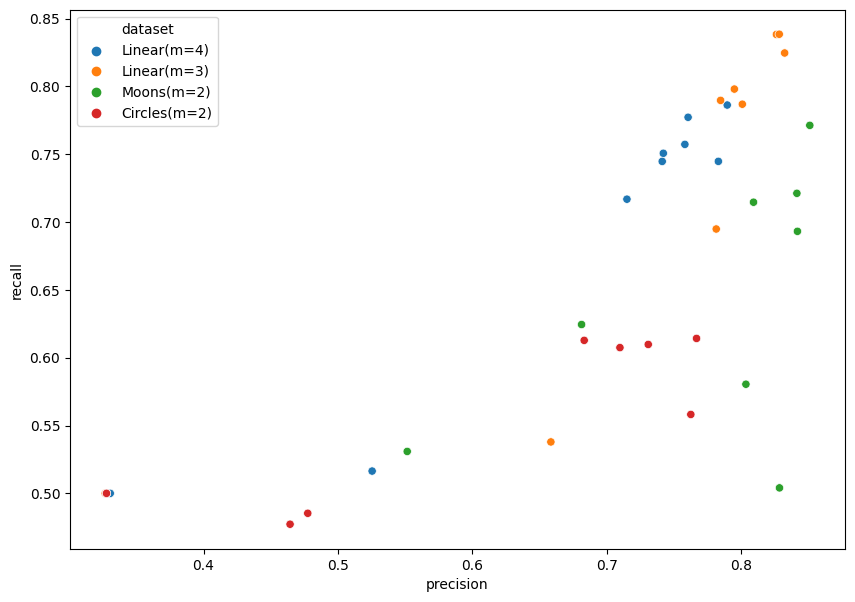

In [47]:
import seaborn as sns
sns.scatterplot(x="precision", y="recall", data=df, hue="dataset")

<AxesSubplot:xlabel='xprecision', ylabel='xrecall'>

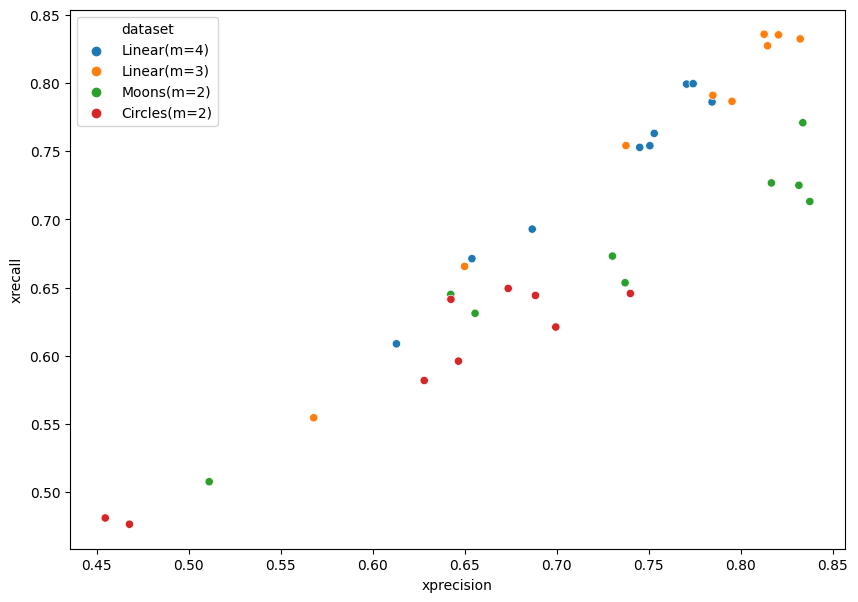

In [48]:
sns.scatterplot(x="xprecision", y="xrecall", data=df, hue="dataset")

<AxesSubplot:xlabel='xf1', ylabel='f1'>

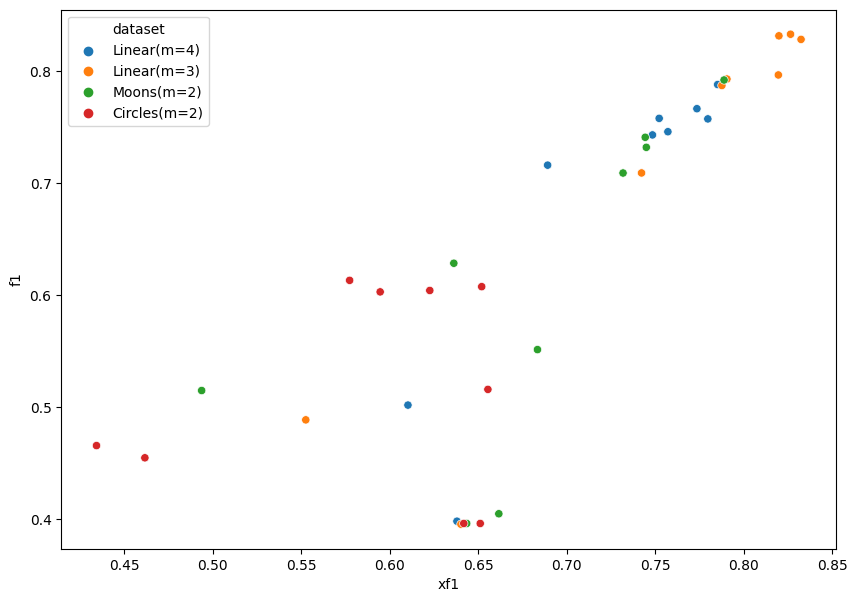

In [49]:
sns.scatterplot(x="xf1", y="f1", data=df, hue="dataset")

In [50]:
df["_model_rank"] = df.groupby("dataset")["xprecision"].rank(ascending=False).astype(int)
df= df.sort_values(['dataset','xprecision'],ascending=False)
model_weight = dict(zip(range(1,10)[::-1], np.linspace(0.25, 1.0, num=9)))
df["_model_score"] = df.apply(lambda x: model_weight[x["_model_rank"]] , axis=1)
df_weighted = df.copy()

In [51]:
cols = ['precision','recall','f1','xprecision','xrecall','xf1']
dcols = ['△precision','△recall','△f1']
for col in cols:
    df_weighted[col] = (df_weighted[col] * df_weighted["_model_score"]) / sum(model_weight.values())
    
df_weighted['△precision'] = df_weighted['xprecision'] - df_weighted['precision']
df_weighted['△recall'] = df_weighted['xrecall'] - df_weighted['recall']
df_weighted['△f1'] = df_weighted['xf1'] - df_weighted['f1']

df_weighted.groupby('dataset').sum()

,num_classes,total_num_examples,total_num_errors,△precision,△recall,△f1,△support,xprecision,precision,xrecall,recall,xf1,f1,xsupport,support,_model_rank,_model_score
dataset,,,,,,,,,,,,,,,,,
Circles(m=2),18,3240,1116,0.048370,0.049315,0.084248,0.0,0.659886,0.611515,0.613397,0.564082,0.613176,0.528928,1620.0,1620.0,45,5.625
Linear(m=3),27,4860,1683,0.010841,0.019636,0.021110,0.0,0.786462,0.775621,0.794875,0.775239,0.787860,0.766750,2430.0,2430.0,45,5.625
Linear(m=4),36,6480,2196,0.021284,0.026646,0.022913,0.0,0.746041,0.724757,0.758314,0.731668,0.747658,0.724745,3240.0,3240.0,45,5.625
Moons(m=2),18,3240,1116,-0.005852,0.039272,0.061581,0.0,0.771506,0.777358,0.695774,0.656502,0.708710,0.647129,1620.0,1620.0,45,5.625


### Is label correct scores

In [52]:
df = pd.DataFrame(clf_pred_probs_scores, index=range(1, 37))
df

,dataset,classifer,num_classes,total_num_examples,total_num_errors,△precision,△recall,△f1,△support,xprecision,precision,xrecall,recall,xf1,f1,xsupport,support
1,Linear(m=4),Naive Bayes,4,720,244,-0.245552,-0.196027,-0.182044,20.0,0.501089,0.746640,0.481848,0.677875,0.480245,0.662289,180.0,160.0
2,Linear(m=4),LogisticReg,4,720,244,-0.245253,-0.194015,-0.177234,20.0,0.491626,0.736879,0.463037,0.657052,0.462904,0.640137,180.0,160.0
3,Linear(m=4),K-NN (K=3),4,720,244,-0.147567,-0.115148,-0.112897,20.0,0.425080,0.572647,0.430112,0.545259,0.427061,0.539958,180.0,160.0
4,Linear(m=4),Linear SVM,4,720,244,-0.269130,-0.194208,-0.188045,20.0,0.463355,0.732484,0.440711,0.634919,0.425205,0.613249,180.0,160.0
5,Linear(m=4),RBF SVM,4,720,244,-0.236814,-0.211485,-0.205730,20.0,0.503122,0.739936,0.498342,0.709828,0.498499,0.704228,180.0,160.0
6,Linear(m=4),Rand Forest,4,720,244,-0.249651,-0.233737,-0.237292,20.0,0.497998,0.747649,0.502451,0.736188,0.497362,0.734654,180.0,160.0
7,Linear(m=4),Neural Net,4,720,244,-0.233393,-0.210395,-0.203533,20.0,0.528753,0.762146,0.516170,0.726565,0.518330,0.721863,180.0,160.0
8,Linear(m=4),AdaBoost,4,720,244,-0.156183,-0.115104,-0.102211,20.0,0.436523,0.592706,0.425657,0.540762,0.425435,0.527646,180.0,160.0
9,Linear(m=4),QDA,4,720,244,-0.234456,-0.195726,-0.186974,20.0,0.519090,0.753546,0.504918,0.700644,0.505203,0.692177,180.0,160.0
10,Linear(m=3),Naive Bayes,3,540,187,-0.233908,-0.187552,-0.195420,20.0,0.537485,0.771393,0.528691,0.716243,0.518762,0.714182,180.0,160.0


# Evaluate All Experiments

## Dictionaries to map to display names

In [53]:
method_adjust_pred_probs_display_dict = {
    "self_confidence-False": "Self Confidence",
    "self_confidence-True": "Adjusted Self Confidence",
    "normalized_margin-False": "Normalized Margin",
    "normalized_margin-True": "Adjusted Normalized Margin",
    "confidence_weighted_entropy-False": "Confidence Weighted Entropy",
    "entropy-False": "Entropy",
    "least_confidence-False": "Least Confidence",
}

## Load files from experiments (can be deprecated in favor of clf_data)

In [104]:
%%time

experiments = []

for data in clf_data:
    dataset = data["dataset"]
    classifier = data["classifer"]
    num_classes = data["num_classes"]
    total_num_examples = data["total_num_examples"]
    clf = data["clf"]
    pred_probs_xval = data["pred_probs_xval"]
    pred_probs_test = data["pred_probs_test"]
    X_train = data["X_train"]
    y_train = data["y_train"]
    X_test = data["X_test"]
    y_test = data["y_test"]
    
    labels = y_train
    label_errors_mask = pred_probs_xval.argmax(1) != labels # boolean mask of label errors
    
    # store results of experiment
    experiment_results = {
        "dataset": dataset,
        "model": classifier,
        "pred_probs": pred_probs_xval,
        "labels": labels,
        "label_errors_mask": label_errors_mask
    }
    
    experiments.append(experiment_results)

CPU times: user 0 ns, sys: 2.09 ms, total: 2.09 ms
Wall time: 1.43 ms


## Prepare data for ensemble model

In [105]:
%%time

dataset_model_output = {}

for i, experiment in enumerate(experiments):

    # experiment results
    dataset = experiment["dataset"]
    model = experiment["model"]
    pred_probs = experiment["pred_probs"]
    labels = experiment["labels"]
    label_errors_target = experiment["label_errors_mask"]

    # check
    if dataset not in dataset_model_output.keys():

        # init list of pred_probs and labels
        dataset_model_output[dataset] = {}
        dataset_model_output[dataset]["pred_probs_list"] = []
        dataset_model_output[dataset]["labels_list"] = []
        dataset_model_output[dataset]["label_errors_target_list"] = []

    # store model output on dataset as key
    dataset_model_output[dataset]["pred_probs_list"].append(pred_probs)
    dataset_model_output[dataset]["labels_list"].append(labels)
    dataset_model_output[dataset]["label_errors_target_list"].append(
        label_errors_target
    )

CPU times: user 39 µs, sys: 27 µs, total: 66 µs
Wall time: 74.6 µs


## Evaluate ensemble model

In [106]:
import sys
import cleanlab
from cleanlab.rank import get_label_quality_scores, get_label_quality_ensemble_scores
from cleanlab.internal.label_quality_utils import get_normalized_entropy

sys.path.insert(0, "../")
from eval_metrics import lift_at_k
from active_learning_scores import least_confidence
#experimental version of label quality ensemble scores with additional weighting schemes
from label_quality_ensemble_scores_experimental import get_label_quality_ensemble_scores_experimental
from experimental_scores import probability_mass_above_given_label_score

from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_fscore_support, f1_score, precision_score, recall_score, precision_recall_curve, accuracy_score, log_loss
from matplotlib import pyplot as plt
from scipy import stats


## Precision/Recall and ROC Area Under Curve

In [130]:
%%time

# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False),
    ("self_confidence", True),
    ("normalized_margin", False),
    ("normalized_margin", True),
    ("confidence_weighted_entropy", False)
]

def benchmark_results(experiments, score_params, plot_curves=True):
    plt.rcParams["figure.figsize"] = (10,5)
    fontsize = 7
    
    evaluations = []
    precision_recall_curves = [] # store this separately
    accuracy_list = []

    for experiment in experiments:

        # experiment results
        dataset = experiment["dataset"]
        model = experiment["model"]
        pred_probs = experiment["pred_probs"]
        labels = experiment["labels"]
        label_errors_target = experiment["label_errors_mask"]

        accuracy = {
            "dataset": dataset,
            "model": model,
            "cv_accuracy": (pred_probs.argmax(axis=1) == labels).mean()
        }

        accuracy_list.append(accuracy)

        #### label quality scoring

        for score_param in score_params:

            # label quality scoring method
            method, adjust_pred_probs = score_param    

            # compute scores
            label_quality_scores = get_label_quality_scores(labels=labels, pred_probs=pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)

            if np.isnan(1-label_quality_scores).any() or np.isnan(label_errors_target).any():
                print(f'method:{method}, adjusted_score_param:{adjust_pred_probs} contains NaN in label_quality_scores. Skipped.')
                continue

            # compute accuracy of detecting label errors
            auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)
            
            # compute mass above given label score. Calling this for adjust_pred_probs=True does not work but lets still benchmark
            if method == "self_confidence":
                mass_above_given_label = probability_mass_above_given_label_score(labels, pred_probs, adjust_pred_probs=adjust_pred_probs, alpha=.99)
                # compute accuracy of detecting label errors using MAGL
                auroc_magl = roc_auc_score(label_errors_target, 1 - mass_above_given_label)
            else: # does not make sense to compute MAGL score for any other method in the same way
                auroc_magl = None

            # lift at K where K = number of label errors
            lift_at_num_label_errors = lift_at_k(label_errors_target, 1 - label_quality_scores, k=label_errors_target.sum())

            # lift at k=100
            lift_at_100 = lift_at_k(label_errors_target, 1 - label_quality_scores, k=100)

            evaluation_results = {
                "method": method,
                "adjust_pred_probs": adjust_pred_probs,
                "dataset": dataset,
                "model": model,
                "accuracy": (pred_probs.argmax(axis=1) == labels).mean(),
                "dataset_num_samples": labels.shape[0],
                "dataset_num_label_errors": label_errors_target.sum(),
                "auroc": auroc,
                "auroc_magl": auroc_magl,
                "lift_at_num_label_errors": lift_at_num_label_errors,
                "lift_at_100": lift_at_100            
            }

            # store evaluation results
            evaluations.append(evaluation_results)

            # compute precision-recall curve using label quality scores
            precision, recall, thresholds = precision_recall_curve(label_errors_target, 1 - label_quality_scores) 
            
            # compute au-roc curve using label quality scores
            fpr, tpr, roc_thresholds = roc_curve(label_errors_target,  1 - label_quality_scores)    

            precision_recall_curve_results = {
                "method": method,
                "adjust_pred_probs": adjust_pred_probs,
                "dataset": dataset,
                "model": model,
                "label_quality_scores": label_quality_scores,
                "precision": precision,
                "recall": recall,
                "thresholds": thresholds,
                "fpr": fpr,
                "tpr": tpr,
                "roc_thresholds": roc_thresholds,
            }

            # store precision-recall curve results
            precision_recall_curves.append(precision_recall_curve_results)

            if plot_curves:
                plt.suptitle(f"Label Error Detection with model: {model} with dataset: {dataset}", fontsize=12, fontweight="bold")
                # plot prc
                plt.subplot(1, 2, 1)
                plt.plot(recall, precision, label=f"{method}-{str(adjust_pred_probs)}")
                plt.xlabel("Recall", fontsize=fontsize)
                plt.ylabel("Precision", fontsize=fontsize)
                plt.title(f"Precision-Recall Curve for LQS", fontsize=fontsize, fontweight="bold")
                plt.legend(fontsize=fontsize)

                # plot roc
                plt.subplot(1, 2, 2)
                plt.plot(fpr, tpr, label=f"{method}-{str(adjust_pred_probs)}")
                plt.xlabel("False Positive Rate", fontsize=fontsize)
                plt.ylabel("True Positive Rate", fontsize=fontsize)
                plt.title(f"AU ROC Curve for LQS", fontsize=fontsize, fontweight="bold")
                plt.legend(fontsize=fontsize)
        
        #### active learning scores to use as comparison

        al_scoring_funcs = {
            "entropy": get_normalized_entropy,
            "least_confidence": least_confidence
        }

        for al_method in al_scoring_funcs.keys():

            # active learning scoring function
            scoring_func = al_scoring_funcs[al_method]

            # score
            al_scores = scoring_func(pred_probs)

            # compute accuracy of detecting label errors
            auroc = roc_auc_score(label_errors_target, al_scores)

            # lift at K where K = number of label errors
            lift_at_num_label_errors = lift_at_k(label_errors_target, al_scores, k=label_errors_target.sum())

            # lift at k=100
            lift_at_100 = lift_at_k(label_errors_target, al_scores, k=100)

            evaluation_results = {
                "method": al_method,
                "adjust_pred_probs": False,
                "dataset": dataset,
                "model": model,
                "dataset_num_samples": labels.shape[0],
                "dataset_num_label_errors": label_errors_target.sum(),
                "auroc": auroc,
                "lift_at_num_label_errors": lift_at_num_label_errors,
                "lift_at_100": lift_at_100,
            }

            # store evaluation results
            evaluations.append(evaluation_results)
    
        if plot_curves:
            plt.show()
    
    return evaluations, precision_recall_curves, accuracy_list

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 17.6 µs


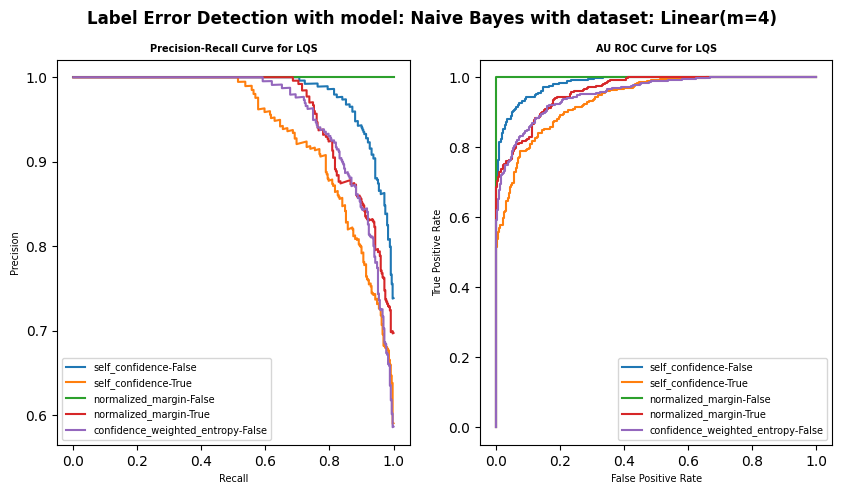

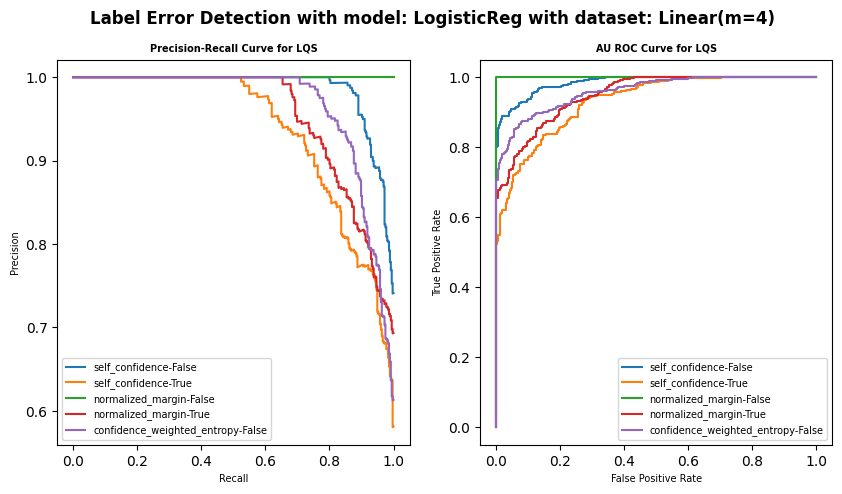

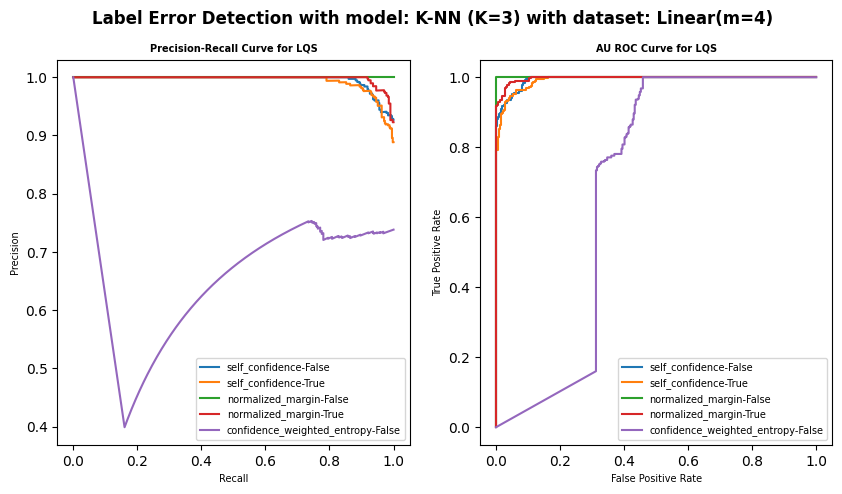

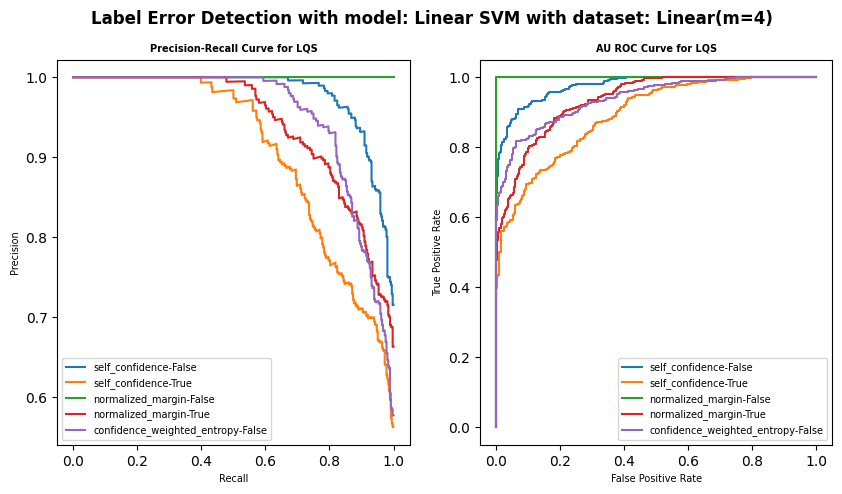

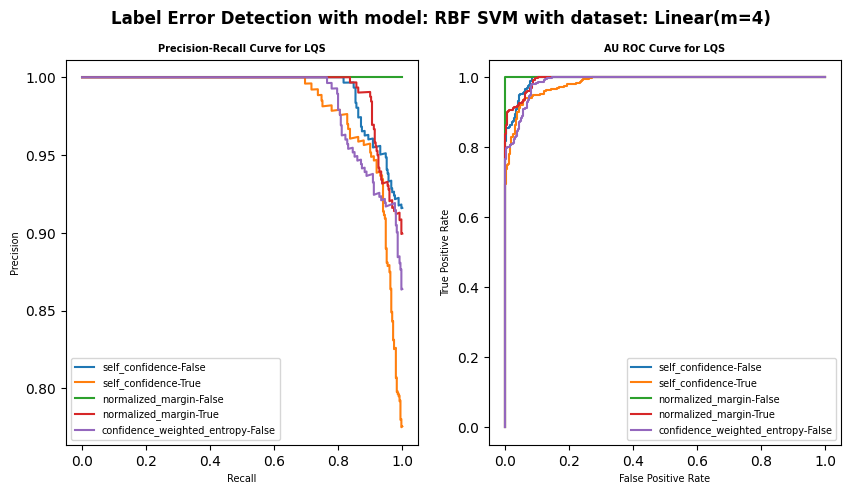

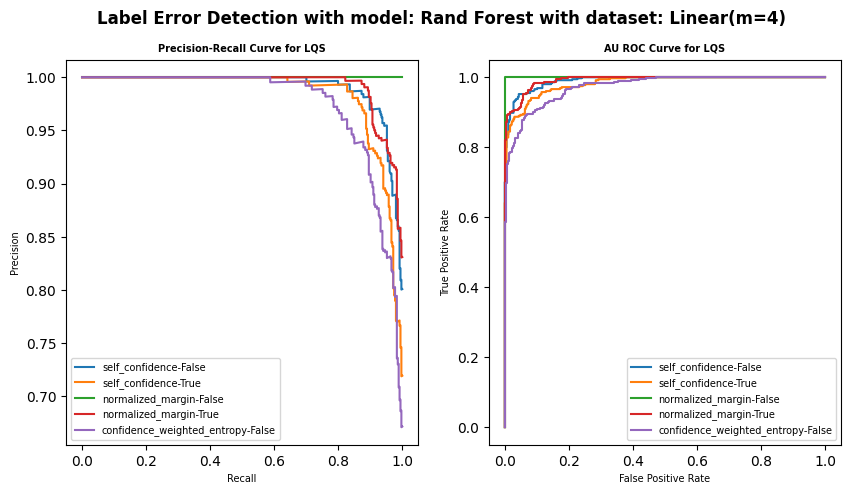

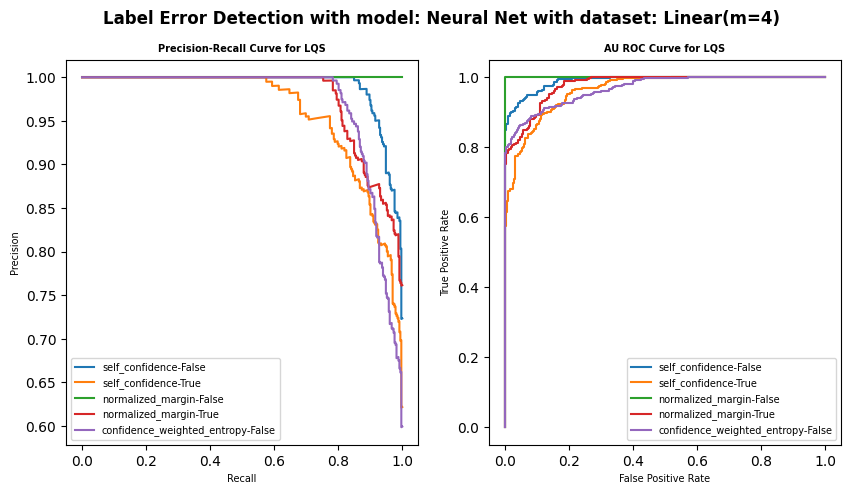

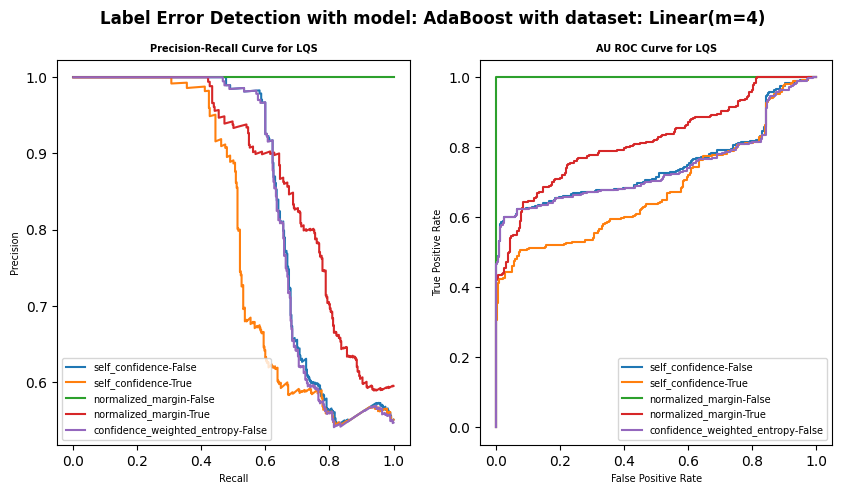

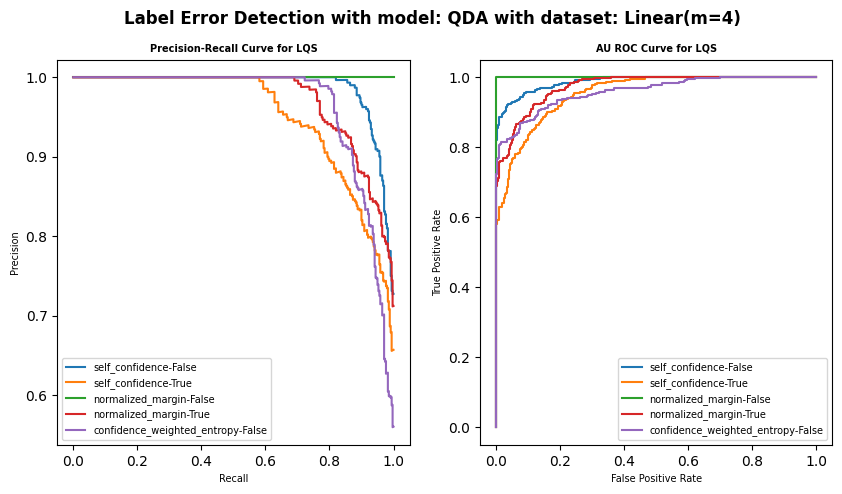

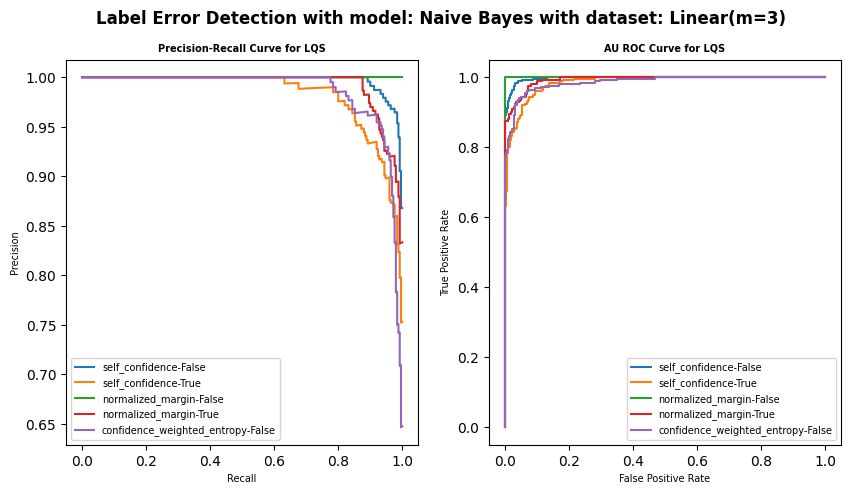

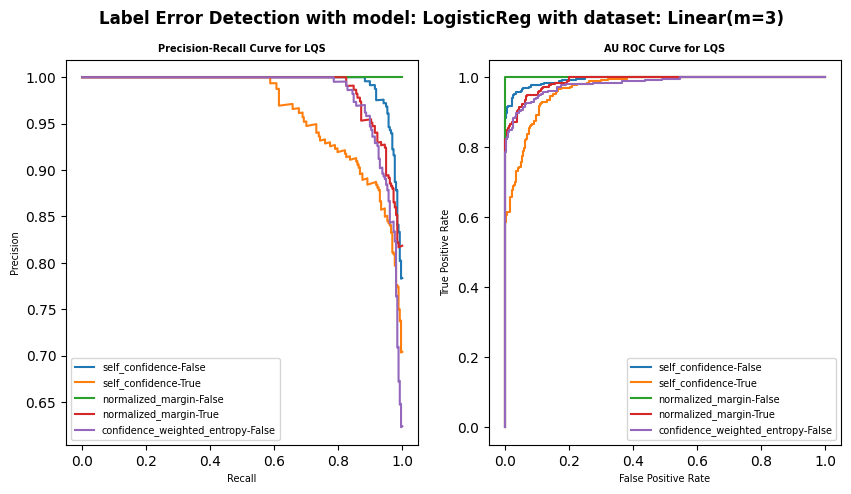

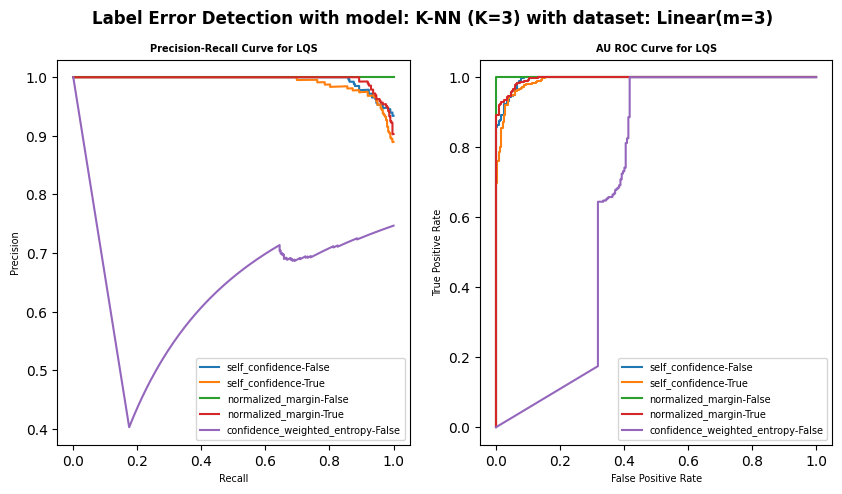

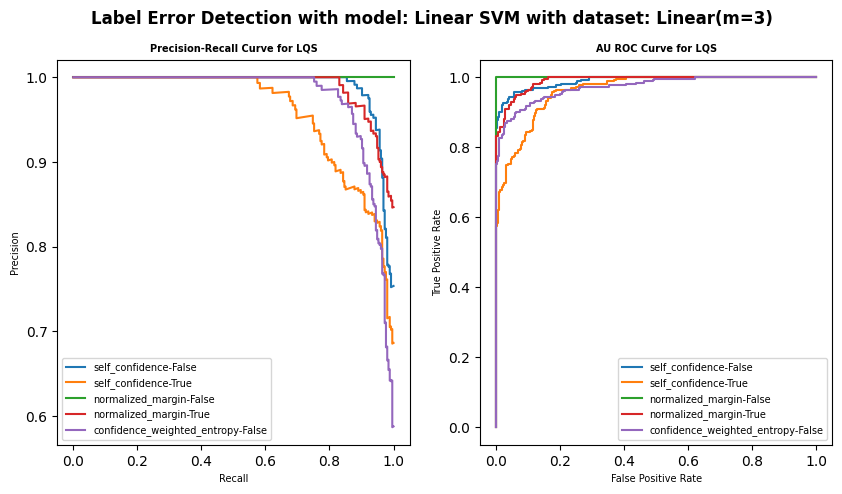

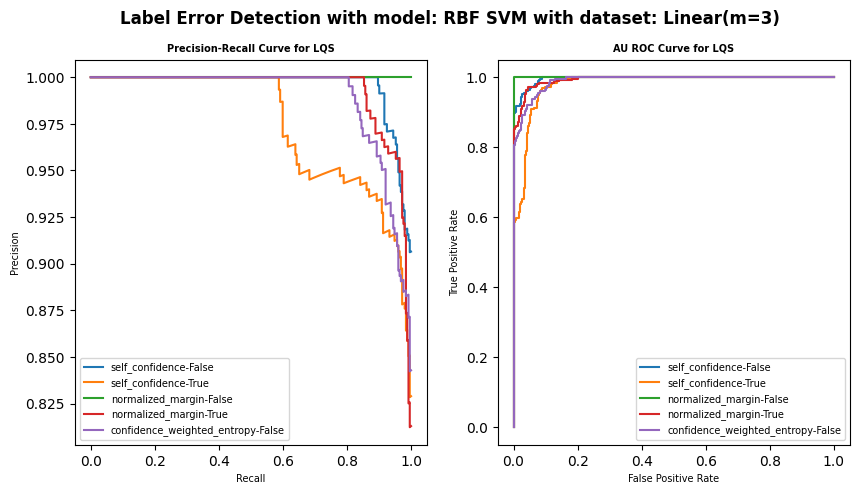

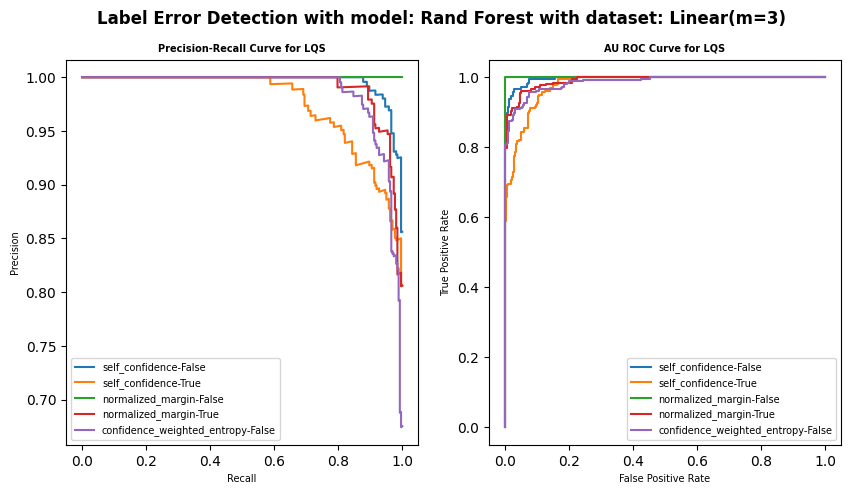

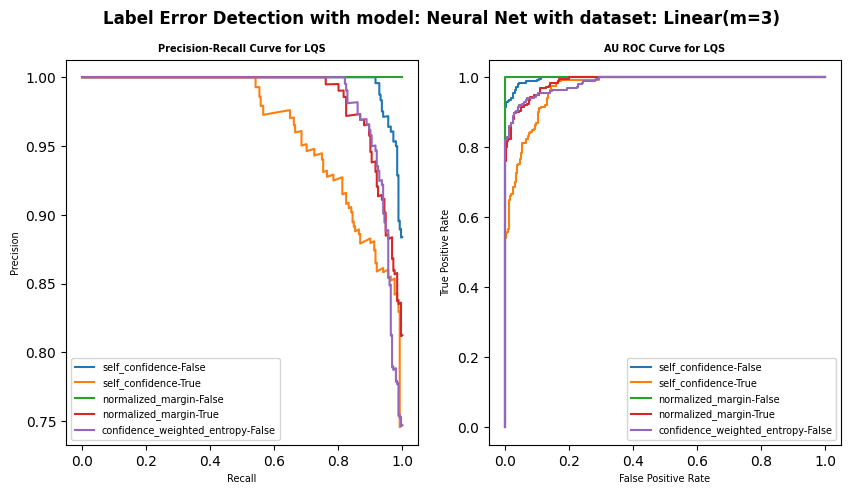

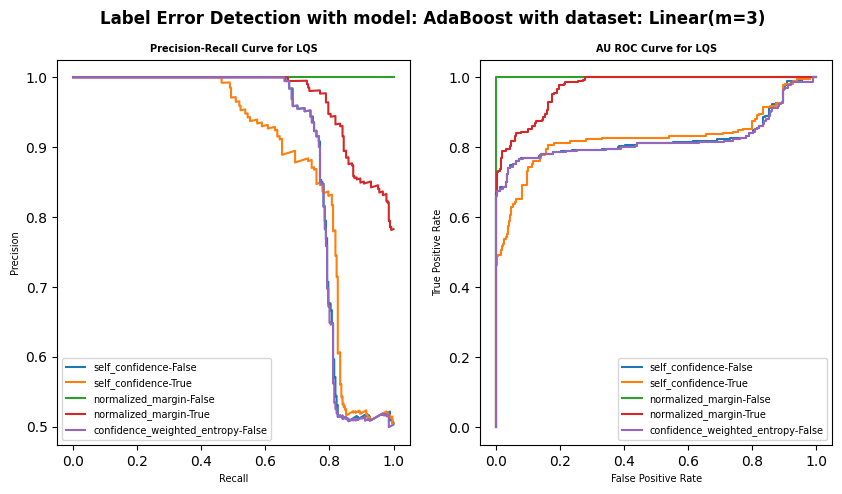

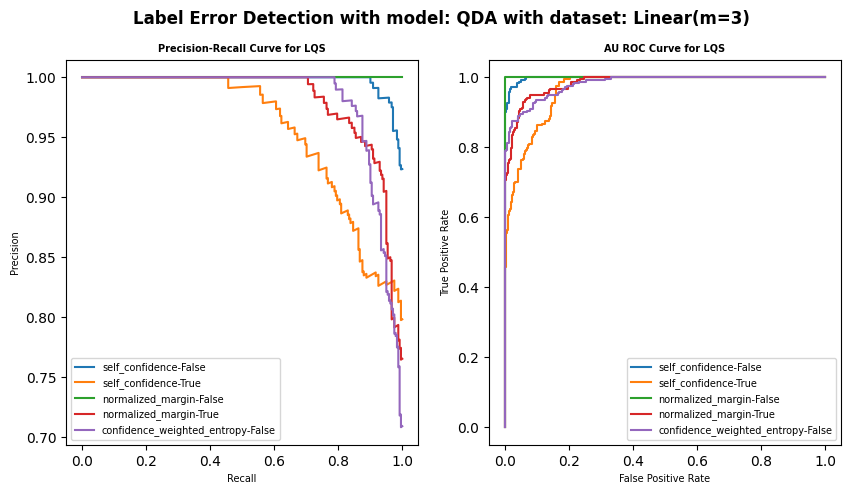

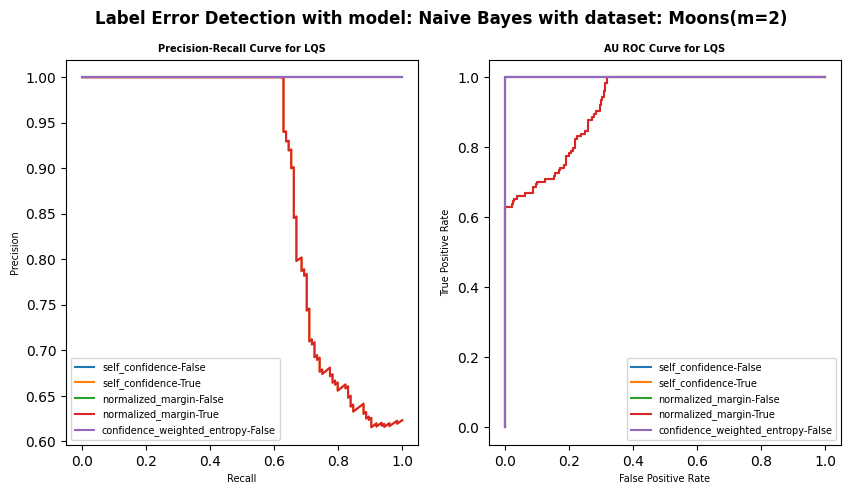

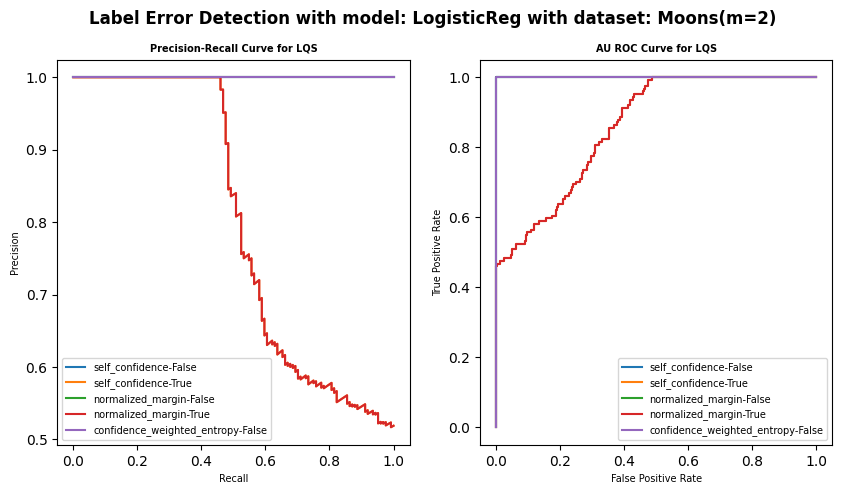

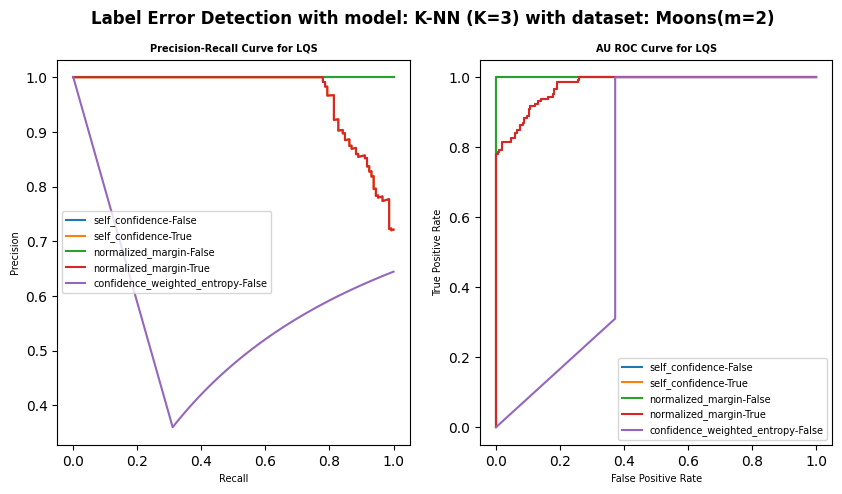

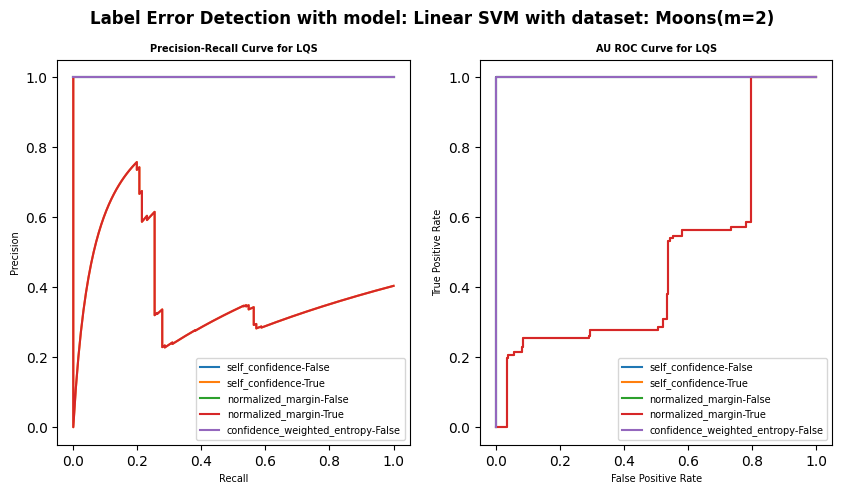

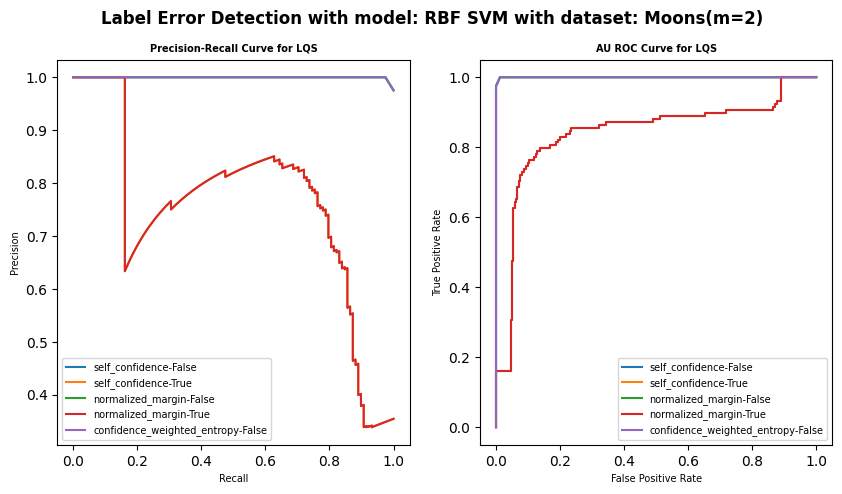

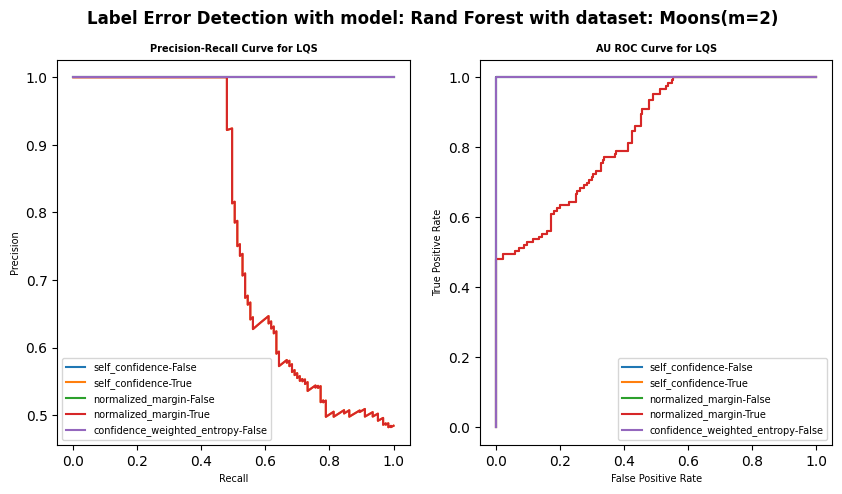

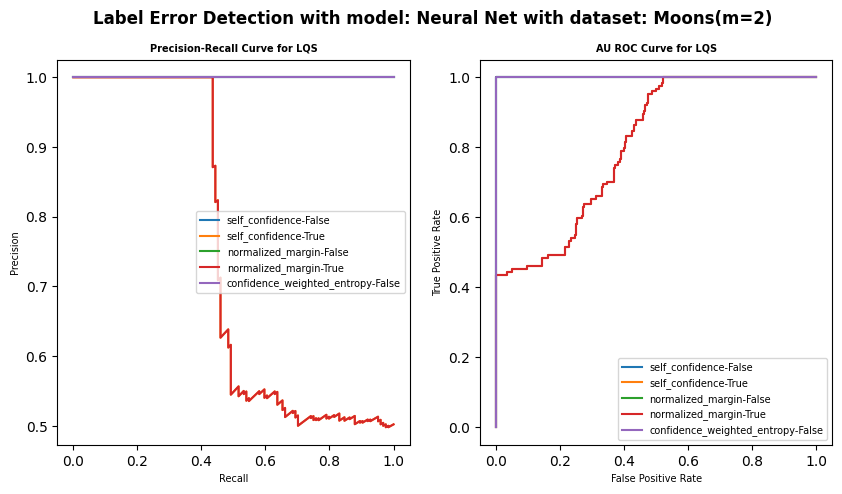

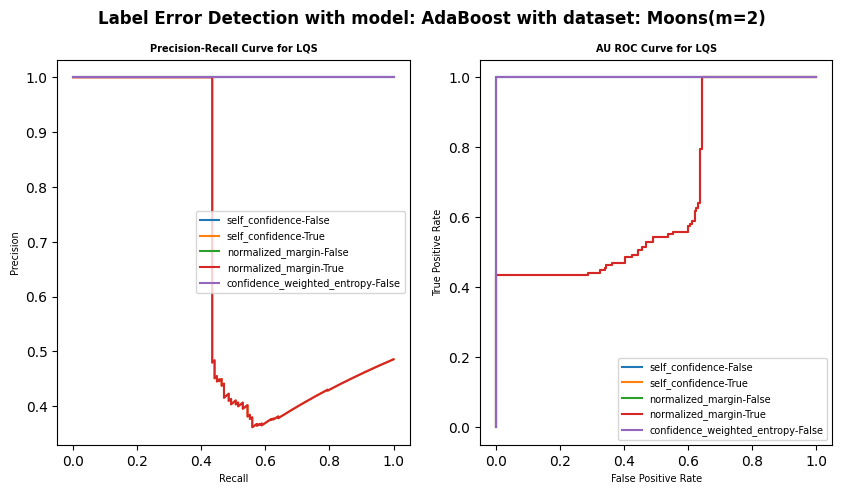

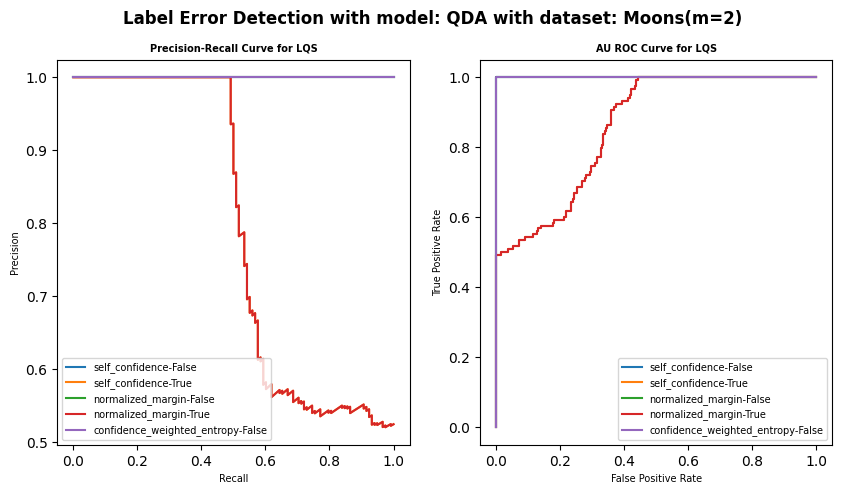

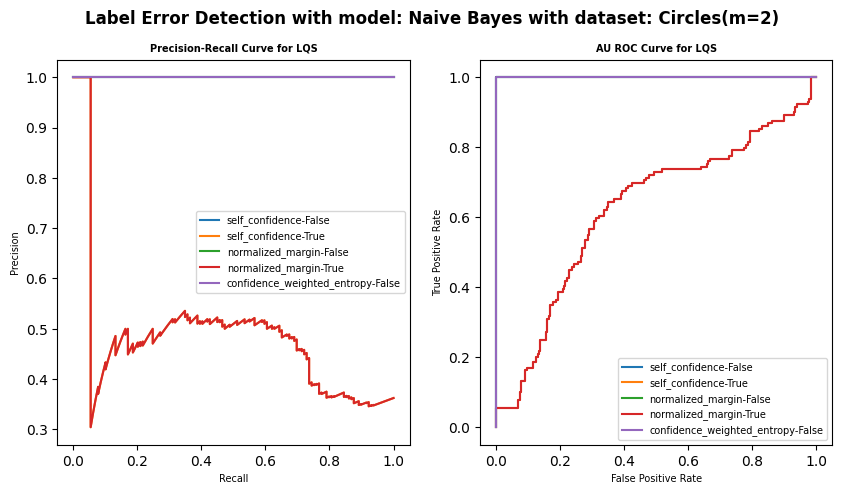

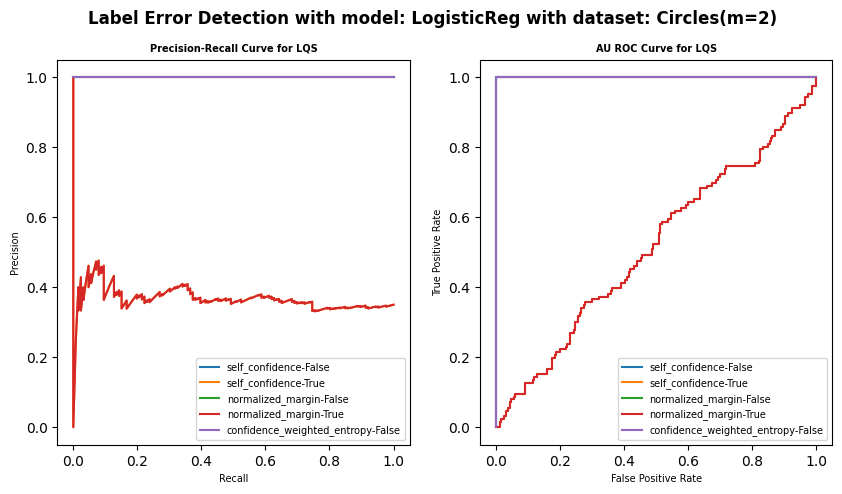

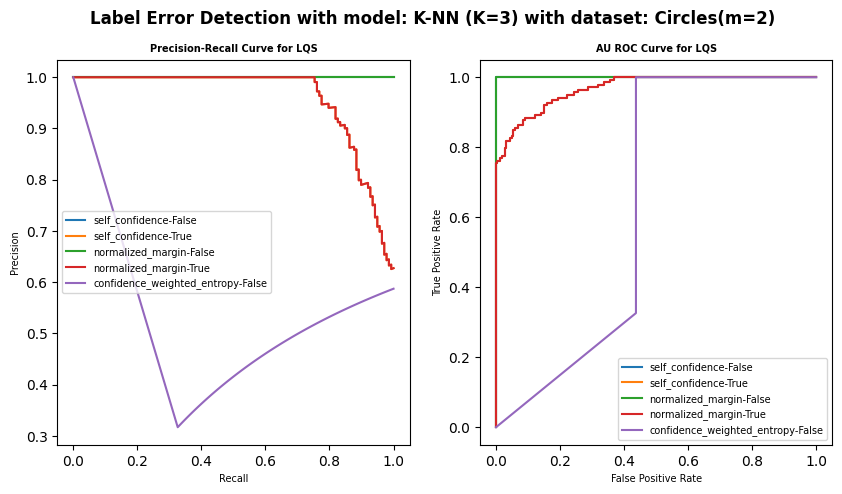

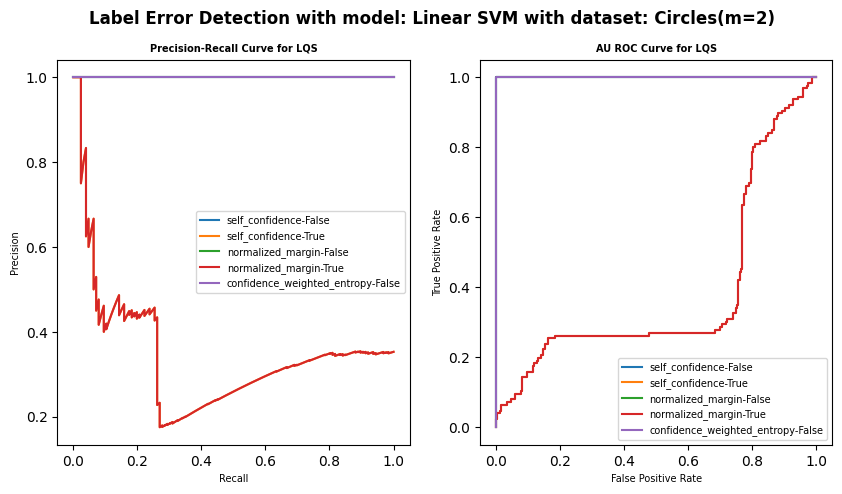

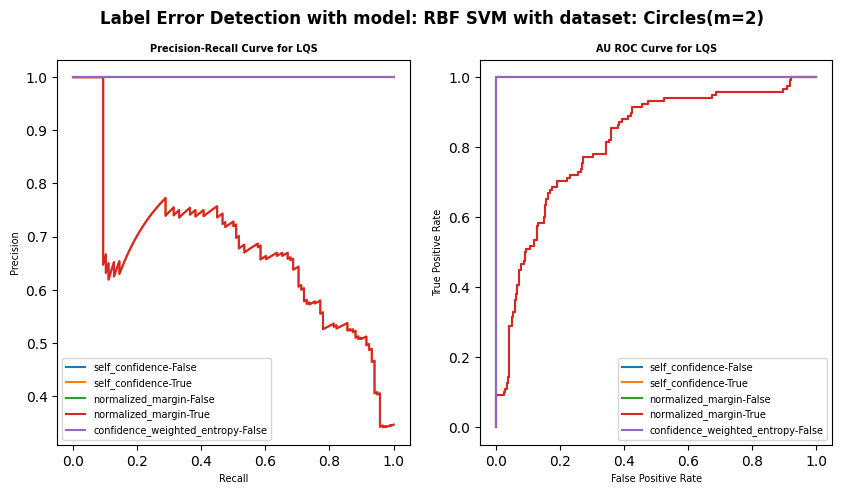

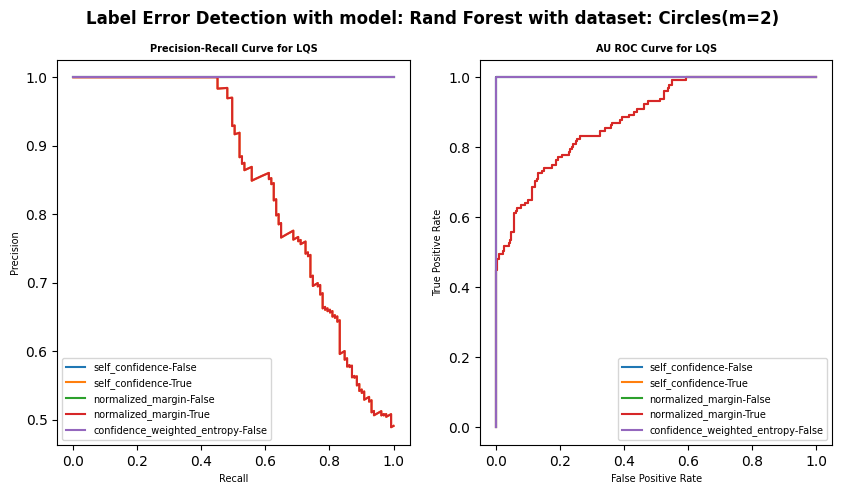

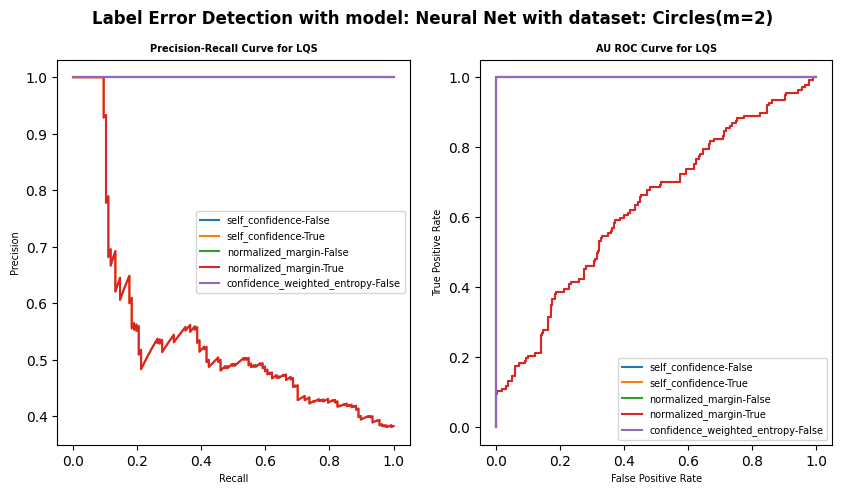

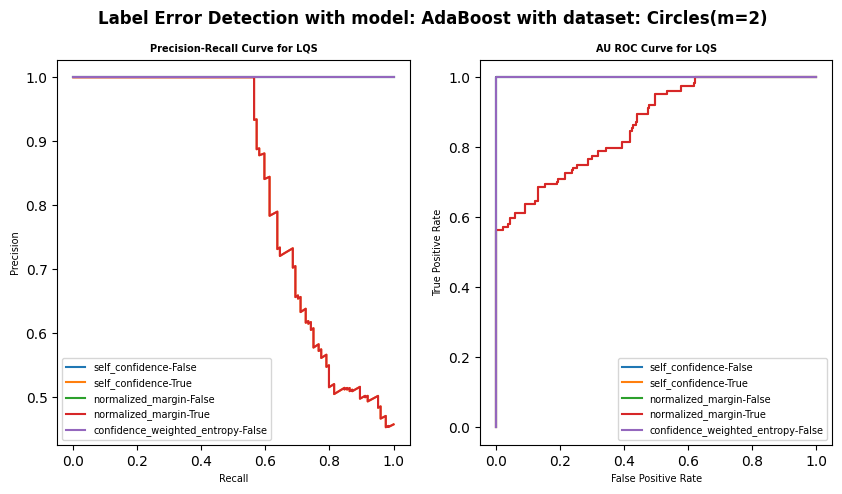

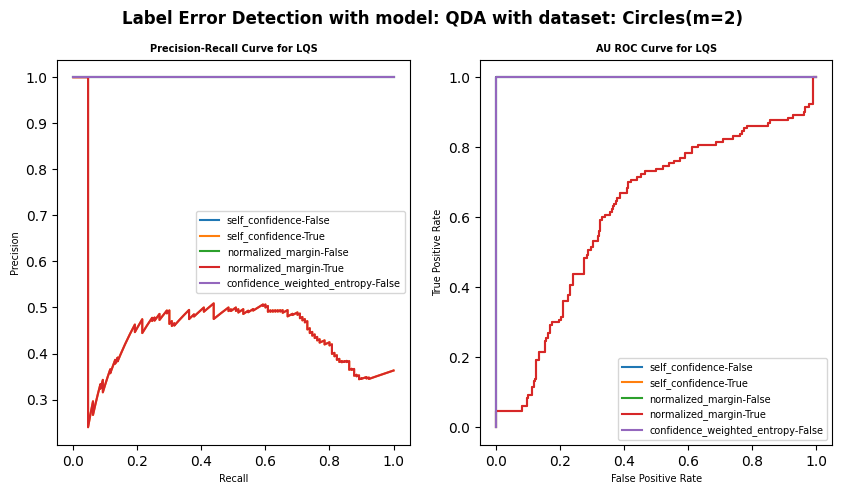

In [131]:
evaluations, precision_recall_curves, accuracy_list = benchmark_results(experiments, score_params, plot_curves=True)

In [132]:
pd.DataFrame(evaluations)

,method,adjust_pred_probs,dataset,model,accuracy,dataset_num_samples,dataset_num_label_errors,auroc,auroc_magl,lift_at_num_label_errors,lift_at_100
0,self_confidence,False,Linear(m=4),Naive Bayes,0.513889,720,350,0.983019,1.000000,1.898449,2.057143
1,self_confidence,True,Linear(m=4),Naive Bayes,0.513889,720,350,0.937290,0.807158,1.745633,2.057143
2,normalized_margin,False,Linear(m=4),Naive Bayes,0.513889,720,350,1.000000,NaN,2.057143,2.057143
3,normalized_margin,True,Linear(m=4),Naive Bayes,0.513889,720,350,0.961135,NaN,1.798531,2.057143
4,confidence_weighted_entropy,False,Linear(m=4),Naive Bayes,0.513889,720,350,0.954147,NaN,1.792653,2.057143
...,...,...,...,...,...,...,...,...,...,...,...
247,normalized_margin,False,Circles(m=2),QDA,0.638889,360,130,1.000000,NaN,2.769231,2.769231
248,normalized_margin,True,Circles(m=2),QDA,0.638889,360,130,0.618294,NaN,1.363314,1.329231
249,confidence_weighted_entropy,False,Circles(m=2),QDA,0.638889,360,130,1.000000,NaN,2.769231,2.769231
250,entropy,False,Circles(m=2),QDA,NaN,360,130,0.610334,NaN,1.235503,1.190769


## Original Metrics

In [109]:
%%time

# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False),
    ("self_confidence", True),
    ("normalized_margin", False),
    ("normalized_margin", True),
    ("confidence_weighted_entropy", False)
]


ensemble_evaluations = []

dataset_best_weights = []

for dataset_key in dataset_model_output.keys():

    # get list of pred_probs, labels for dataset
    pred_probs_list = dataset_model_output[dataset_key]["pred_probs_list"]
    labels_list = dataset_model_output[dataset_key]["labels_list"]
    label_errors_target_list = dataset_model_output[dataset_key]["label_errors_target_list"]
    
#     # use for sanity check (noisy labels and images from each model should be the same because they were generated from the same cross-val procedure
#     for i, labels_temp in enumerate(labels_list):
#         if i == 0:
#             labels_temp_previous = copy.deepcopy(labels_temp)
#         else:
#             assert (labels_temp_previous == labels_temp).all()
    
    # take the first (the others are the same)
    labels = labels_list[0]
    label_errors_target = label_errors_target_list[0]
    
    # compute accuracy
    accuracy_list = []
    for pred_probs in pred_probs_list:
        
        # accuracy of single model
        accuracy = (pred_probs.argmax(axis=1) == labels).mean()
        accuracy_list.append(accuracy)
        
    # accuracy weights
    acc_weights = np.array(accuracy_list) / sum(accuracy_list)    
    
    # average predictions
    pred_probs_avg = sum(pred_probs_list) / len(pred_probs_list)
    
    #### can refactor below to a function that accepts weights and pred_probs_list
    
    # accuracy-weighted predictions
    pred_probs_avg_acc_weighted = sum([acc_weights[i] * p for i, p in enumerate(pred_probs_list)])
    

    #### find best t in T for exp-log-loss weighting
    T = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 2e2]

    pred_probs_avg_log_loss_weighted = None
    inv_log_loss_weights = None
    best_eval_log_loss = float("inf")
    best_t = None

    for t in T:

        log_loss_list = []

        # pred_probs for each model
        for pred_probs in pred_probs_list:
            log_loss_ = np.exp(t * (-log_loss(labels, pred_probs)))
            log_loss_list.append(log_loss_)

        # weights using log loss
        inv_log_loss_weights_temp = np.array(log_loss_list) / sum(log_loss_list)

        # weighted average
        pred_probs_avg_log_loss_weighted_temp = sum([inv_log_loss_weights_temp[i] * p for i, p in enumerate(pred_probs_list)])

        # evaluate log_loss with this weighted average
        eval_log_loss = log_loss(labels, pred_probs_avg_log_loss_weighted_temp)


        # check if this is the best eval_log_loss so far
        if best_eval_log_loss > eval_log_loss:
            best_eval_log_loss = eval_log_loss
            best_t = t
            pred_probs_avg_log_loss_weighted = pred_probs_avg_log_loss_weighted_temp.copy()
            inv_log_loss_weights = inv_log_loss_weights_temp.copy()    

    df_temp = pd.DataFrame({
        "dataset": dataset_key,
        "best_t": best_t,
        "best_eval_log_loss": best_eval_log_loss,
        "inv_log_loss_weights": inv_log_loss_weights,
    })
    
    # save the weights for analysis later
    dataset_best_weights.append(df_temp)
    
    #### label quality scoring
    
    for score_param in score_params:
        
        # label quality scoring method
        method, adjust_pred_probs = score_param
    
        # compute scores
        
        # use average pred_probs
        label_quality_scores_avg = get_label_quality_scores(labels=labels, pred_probs=pred_probs_avg, method=method, adjust_pred_probs=adjust_pred_probs)
        
        # use average pred_probs weighted by accuracy
        label_quality_scores_avg_acc_weighted = get_label_quality_scores(labels=labels, pred_probs=pred_probs_avg_acc_weighted, method=method, adjust_pred_probs=adjust_pred_probs)
        
        # use average pred_probs weighted by log loss
        label_quality_scores_avg_log_loss_weighted = get_label_quality_scores(labels=labels, pred_probs=pred_probs_avg_log_loss_weighted, method=method, adjust_pred_probs=adjust_pred_probs)   
        
        # use pred_probs_list (weighted by accuracy)
        label_quality_scores_agg_acc = get_label_quality_ensemble_scores_experimental(
            labels=labels, 
            pred_probs_list=pred_probs_list, 
            method=method, 
            adjust_pred_probs=adjust_pred_probs, 
            verbose=0,
            weight_ensemble_members_by="accuracy"
        )

        # use pred_probs_list (uniform_weights)
        label_quality_scores_agg_uni = get_label_quality_ensemble_scores_experimental(
            labels=labels, 
            pred_probs_list=pred_probs_list, 
            method=method, 
            adjust_pred_probs=adjust_pred_probs,
            verbose=0,
            weight_ensemble_members_by="uniform"
        )
        
        # use pred_probs_list (weight by inverse log loss)
        label_quality_scores_agg_log_loss = get_label_quality_ensemble_scores_experimental(
            labels=labels, 
            pred_probs_list=pred_probs_list, 
            method=method, 
            adjust_pred_probs=adjust_pred_probs,
            verbose=0, 
            weight_ensemble_members_by="custom",
            custom_weights=inv_log_loss_weights # custom weights!
        ) 
        
        # compute accuracy of detecting label errors
        auroc_avg = roc_auc_score(label_errors_target, 1 - label_quality_scores_avg)
        auroc_avg_acc_weighted = roc_auc_score(label_errors_target, 1 - label_quality_scores_avg_acc_weighted)
        auroc_avg_log_loss_weighted = roc_auc_score(label_errors_target, 1 - label_quality_scores_avg_log_loss_weighted)        
        
        auroc_agg_acc = roc_auc_score(label_errors_target, 1 - label_quality_scores_agg_acc)
        auroc_agg_uni = roc_auc_score(label_errors_target, 1 - label_quality_scores_agg_uni)
        auroc_agg_log_loss = roc_auc_score(label_errors_target, 1 - label_quality_scores_agg_log_loss)        
        
        # lift at K where K = number of label errors
        lift_at_num_label_errors_avg = lift_at_k(label_errors_target, 1 - label_quality_scores_avg, k=label_errors_target.sum())
        lift_at_num_label_errors_avg_acc_weighted = lift_at_k(label_errors_target, 1 - label_quality_scores_avg_acc_weighted, k=label_errors_target.sum())
        lift_at_num_label_errors_avg_log_loss_weighted = lift_at_k(label_errors_target, 1 - label_quality_scores_avg_log_loss_weighted, k=label_errors_target.sum())
        
        lift_at_num_label_errors_agg_acc = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_acc, k=label_errors_target.sum())
        lift_at_num_label_errors_agg_uni = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_uni, k=label_errors_target.sum())
        lift_at_num_label_errors_agg_log_loss = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_log_loss, k=label_errors_target.sum())        
        
        # lift at k=100
        lift_at_100_avg = lift_at_k(label_errors_target, 1 - label_quality_scores_avg, k=100)
        lift_at_100_avg_acc_weighted = lift_at_k(label_errors_target, 1 - label_quality_scores_avg_acc_weighted, k=100)
        lift_at_100_avg_log_loss_weighted = lift_at_k(label_errors_target, 1 - label_quality_scores_avg_log_loss_weighted, k=100)
        
        lift_at_100_agg_acc = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_acc, k=100)
        lift_at_100_agg_uni = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_uni, k=100)
        lift_at_100_agg_log_loss = lift_at_k(label_errors_target, 1 - label_quality_scores_agg_log_loss, k=100)        

        ensemble_evaluation_results_avg = {
            "ensemble_method": "avg_pred_probs",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_avg,
            "lift_at_num_label_errors": lift_at_num_label_errors_avg,
            "lift_at_100": lift_at_100_avg
        }
        
        ensemble_evaluation_results_avg_acc_weighted = {
            "ensemble_method": "avg_pred_probs_weighted_by_accuracy",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_avg_acc_weighted,
            "lift_at_num_label_errors": lift_at_num_label_errors_avg_acc_weighted,
            "lift_at_100": lift_at_100_avg_acc_weighted
        }        
        
        ensemble_evaluation_results_avg_log_loss_weighted = {
            "ensemble_method": "avg_pred_probs_weighted_by_inv_log_loss",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_avg_log_loss_weighted,
            "lift_at_num_label_errors": lift_at_num_label_errors_avg_log_loss_weighted,
            "lift_at_100": lift_at_100_avg_log_loss_weighted
        }                
        
        ensemble_evaluation_results_agg_acc = {
            "ensemble_method": "avg_scores_weighted_by_accuracy",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_agg_acc,
            "lift_at_num_label_errors": lift_at_num_label_errors_agg_acc,
            "lift_at_100": lift_at_100_agg_acc
        }
        
        ensemble_evaluation_results_agg_uni = {
            "ensemble_method": "avg_scores",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_agg_uni,
            "lift_at_num_label_errors": lift_at_num_label_errors_agg_uni,
            "lift_at_100": lift_at_100_agg_uni
        }
        
        ensemble_evaluation_results_agg_log_loss = {
            "ensemble_method": "avg_scores_weighted_by_inv_log_loss",
            "method": method,
            "adjust_pred_probs": adjust_pred_probs,
            "dataset": dataset_key,
            "model": "ensemble",
            "dataset_num_samples": labels.shape[0],
            "dataset_num_label_errors": label_errors_target.sum(),
            "auroc": auroc_agg_log_loss,
            "lift_at_num_label_errors": lift_at_num_label_errors_agg_log_loss,
            "lift_at_100": lift_at_100_agg_log_loss
        }
        
        # store evaluation results
        ensemble_evaluations.append(ensemble_evaluation_results_avg)
        ensemble_evaluations.append(ensemble_evaluation_results_avg_acc_weighted)
        ensemble_evaluations.append(ensemble_evaluation_results_avg_log_loss_weighted)
        
        ensemble_evaluations.append(ensemble_evaluation_results_agg_acc)
        ensemble_evaluations.append(ensemble_evaluation_results_agg_uni)
        ensemble_evaluations.append(ensemble_evaluation_results_agg_log_loss)

Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
Ensemble scoring using custom weights!
CPU times: user 2.43 s, sys: 15.2 ms, total: 2.44 s
Wall time: 2.43 s


In [110]:
df_evaluations_ensemble = pd.DataFrame(ensemble_evaluations)


df_evaluations_ensemble["method_adjust_pred_probs"] = (
    df_evaluations_ensemble.method
    + "-"
    + df_evaluations_ensemble.adjust_pred_probs.astype(str)
)
df_evaluations_ensemble["dataset_model"] = (
    df_evaluations_ensemble.dataset + " | " + df_evaluations_ensemble.model
)

df_evaluations_ensemble[
    "scoring_method"
] = df_evaluations_ensemble.method_adjust_pred_probs.map(
    lambda x: method_adjust_pred_probs_display_dict[x]
)

In [111]:
df_evaluations_ensemble.groupby("ensemble_method")["ensemble_method"].count()

ensemble_method
avg_pred_probs                             20
avg_pred_probs_weighted_by_accuracy        20
avg_pred_probs_weighted_by_inv_log_loss    20
avg_scores                                 20
avg_scores_weighted_by_accuracy            20
avg_scores_weighted_by_inv_log_loss        20
Name: ensemble_method, dtype: int64

In [112]:
df_evaluations_ensemble_pivot = pd.pivot_table(
    df_evaluations_ensemble,
    values="auroc",
    index=["scoring_method", "ensemble_method"],
    columns=["dataset"],
).reset_index()

In [113]:
df_evaluations_ensemble_auroc = (
    pd.pivot_table(
        df_evaluations_ensemble,
        values="auroc",
        index=["dataset", "scoring_method"],
        columns=["ensemble_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "scoring_method"])
)

df_evaluations_ensemble_lift_at_num_errors = (
    pd.pivot_table(
        df_evaluations_ensemble,
        values="lift_at_num_label_errors",
        index=["dataset", "scoring_method"],
        columns=["ensemble_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "scoring_method"])
)

df_evaluations_ensemble_lift_at_100 = (
    pd.pivot_table(
        df_evaluations_ensemble,
        values="lift_at_100",
        index=["dataset", "scoring_method"],
        columns=["ensemble_method"],
    )
    .reset_index()
    .sort_values(by=["dataset", "scoring_method"])
)

df_evaluations_ensemble_auroc["dataset_scoring_method"] = \
    df_evaluations_ensemble_auroc.dataset + " | " + df_evaluations_ensemble_auroc.scoring_method

df_evaluations_ensemble_lift_at_num_errors["dataset_scoring_method"] = \
    df_evaluations_ensemble_lift_at_num_errors.dataset + " | " + df_evaluations_ensemble_lift_at_num_errors.scoring_method

df_evaluations_ensemble_lift_at_100["dataset_scoring_method"] = \
    df_evaluations_ensemble_lift_at_100.dataset + " | " + df_evaluations_ensemble_lift_at_100.scoring_method

In [122]:
df_evaluations.head()

,method,adjust_pred_probs,dataset,model,dataset_num_samples,dataset_num_label_errors,auroc,auroc_magl,lift_at_num_label_errors,lift_at_100
0,self_confidence,False,Linear(m=4),Naive Bayes,720,350,0.983019,1.000000,1.898449,2.057143
1,self_confidence,True,Linear(m=4),Naive Bayes,720,350,0.937290,0.807158,1.745633,2.057143
2,normalized_margin,False,Linear(m=4),Naive Bayes,720,350,1.000000,NaN,2.057143,2.057143
3,normalized_margin,True,Linear(m=4),Naive Bayes,720,350,0.961135,NaN,1.798531,2.057143
4,confidence_weighted_entropy,False,Linear(m=4),Naive Bayes,720,350,0.954147,NaN,1.792653,2.057143


In [133]:
# master table with AUROC and Lift at K evaluation metrics for all methods, datasets, and models
df_evaluations = pd.DataFrame(evaluations)

In [134]:
df_evaluations["method_adjust_pred_probs"] = (
    df_evaluations.method + "-" + df_evaluations.adjust_pred_probs.astype(str)
)
df_evaluations["dataset_model"] = df_evaluations.dataset + " | " + df_evaluations.model

df_evaluations["scoring_method"] = df_evaluations.method_adjust_pred_probs.map(
    lambda x: method_adjust_pred_probs_display_dict[x]
)
df_evaluations["model_name"] = df_evaluations.model.map(
    lambda x: x
)


df_evaluations["model_name_w_acc"] = df_evaluations.model_name + " (" + df_evaluations.cv_accuracy.round(4).astype(str) + ") "



AttributeError: 'DataFrame' object has no attribute 'cv_accuracy'

### Final evaluations dataframe based of different scoring params

In [ ]:
df_evaluations.head(3)

### Final evaluations ensemble dataframe AUROC

In [115]:
df_evaluations_ensemble_auroc.head()

ensemble_method,dataset,scoring_method,avg_pred_probs,avg_pred_probs_weighted_by_accuracy,avg_pred_probs_weighted_by_inv_log_loss,avg_scores,avg_scores_weighted_by_accuracy,avg_scores_weighted_by_inv_log_loss,dataset_scoring_method
0,Circles(m=2),Adjusted Normalized Margin,0.588510,0.589315,0.655660,0.588845,0.589684,0.655626,Circles(m=2) | Adjusted Normalized Margin
1,Circles(m=2),Adjusted Self Confidence,0.588510,0.589315,0.655660,0.588845,0.589684,0.655626,Circles(m=2) | Adjusted Self Confidence
2,Circles(m=2),Confidence Weighted Entropy,0.989228,0.989631,0.966475,0.977248,0.979160,0.965804,Circles(m=2) | Confidence Weighted Entropy
3,Circles(m=2),Normalized Margin,0.989228,0.989631,0.966475,0.989228,0.989631,0.966475,Circles(m=2) | Normalized Margin
4,Circles(m=2),Self Confidence,0.989228,0.989631,0.966475,0.989228,0.989631,0.966475,Circles(m=2) | Self Confidence


In [116]:
df_evaluations_ensemble_pivot

dataset,scoring_method,ensemble_method,Circles(m=2),Linear(m=3),Linear(m=4),Moons(m=2)
0,Adjusted Normalized Margin,avg_pred_probs,0.588510,0.950717,0.929027,0.908693
1,Adjusted Normalized Margin,avg_pred_probs_weighted_by_accuracy,0.589315,0.954166,0.932417,0.911530
2,Adjusted Normalized Margin,avg_pred_probs_weighted_by_inv_log_loss,0.655660,0.969503,0.940239,0.924139
3,Adjusted Normalized Margin,avg_scores,0.588845,0.954938,0.930556,0.907805
4,Adjusted Normalized Margin,avg_scores_weighted_by_accuracy,0.589684,0.957959,0.933853,0.910539
5,Adjusted Normalized Margin,avg_scores_weighted_by_inv_log_loss,0.655626,0.970883,0.940239,0.924207
6,Adjusted Self Confidence,avg_pred_probs,0.588510,0.939614,0.914703,0.908693
7,Adjusted Self Confidence,avg_pred_probs_weighted_by_accuracy,0.589315,0.942166,0.916880,0.911530
8,Adjusted Self Confidence,avg_pred_probs_weighted_by_inv_log_loss,0.655660,0.954993,0.924819,0.924139
9,Adjusted Self Confidence,avg_scores,0.588845,0.939600,0.913367,0.907805


### Evaluations ensemble lift at k

In [117]:
df_evaluations_ensemble_lift_at_100.head()

ensemble_method,dataset,scoring_method,avg_pred_probs,avg_pred_probs_weighted_by_accuracy,avg_pred_probs_weighted_by_inv_log_loss,avg_scores,avg_scores_weighted_by_accuracy,avg_scores_weighted_by_inv_log_loss,dataset_scoring_method
0,Circles(m=2),Adjusted Normalized Margin,1.423256,1.423256,1.702326,1.423256,1.423256,1.702326,Circles(m=2) | Adjusted Normalized Margin
1,Circles(m=2),Adjusted Self Confidence,1.423256,1.423256,1.702326,1.423256,1.423256,1.702326,Circles(m=2) | Adjusted Self Confidence
2,Circles(m=2),Confidence Weighted Entropy,2.734884,2.734884,2.623256,2.651163,2.651163,2.651163,Circles(m=2) | Confidence Weighted Entropy
3,Circles(m=2),Normalized Margin,2.734884,2.734884,2.623256,2.734884,2.734884,2.623256,Circles(m=2) | Normalized Margin
4,Circles(m=2),Self Confidence,2.734884,2.734884,2.623256,2.734884,2.734884,2.623256,Circles(m=2) | Self Confidence
